# Исследование данных о продаже игр
В нашем распоряжении данные из открытых источников (исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы и т.д.). Нужно научится выявлять успешность продажи игр. Наша цель-определить закономерности, которые на неё влияют. Это позволит "сделать ставку" на потенциально популярный продукт и спланировать рекламные компании.

Перед нами данные до 2016 года. Сейчас декабрь 2016 г. и интернет-магазин "Стримчик" планирует компанию на 2017-ый год. 

Описание данных:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Наметим план работы:

- Ознакомимся с данными
- Рассмотрим их ближе и обработаем, где это возможно
- Проведём исследовательский анализ данных
- Составим портрет пользователя каждого региона
- Сформулируем гипотезы и проверим их
- Сформулируем общий вывод

## Знакомство с данными и изучение информации о них

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sb
import numpy as np
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [65]:
df = pd.read_csv('/datasets/games.csv')
display(df.head())
df.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


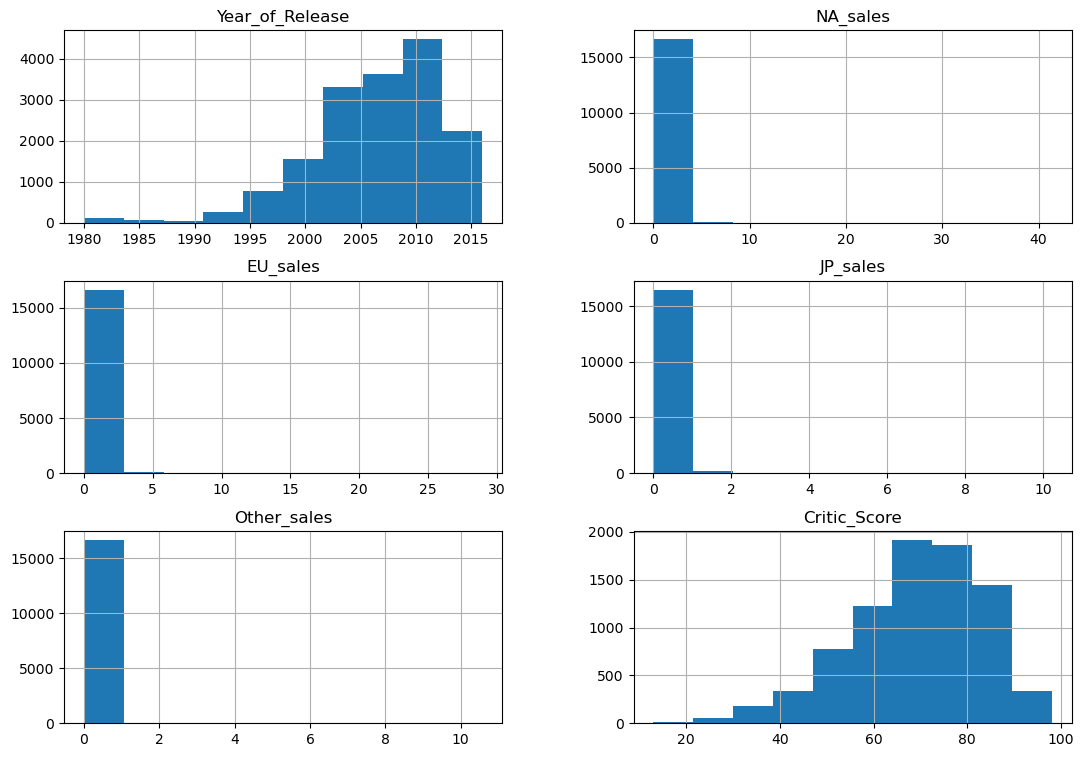

In [8]:
df.hist(figsize=(13, 9))
plt.show()

Проверим наличие/отсутсвие явных дубликатов.

In [9]:
for i in df.columns.unique():
    dup = sum(df[i].duplicated())
    print(f'Количество дубликатов в столбце {i} равно {dup}')

Количество дубликатов в столбце Name равно 5155
Количество дубликатов в столбце Platform равно 16684
Количество дубликатов в столбце Year_of_Release равно 16677
Количество дубликатов в столбце Genre равно 16702
Количество дубликатов в столбце NA_sales равно 16313
Количество дубликатов в столбце EU_sales равно 16408
Количество дубликатов в столбце JP_sales равно 16471
Количество дубликатов в столбце Other_sales равно 16560
Количество дубликатов в столбце Critic_Score равно 16632
Количество дубликатов в столбце User_Score равно 16618
Количество дубликатов в столбце Rating равно 16706


Первый взгляд на данные сделан! Явных дубликатов в данных очень много, но они не повлияют на результаты нашего исследования потому что в большинстве случаев в столбцах категориальные данные. Что касается столбца `name`-одну и ту же игру могли перевыпускать на разные платформы или с дополнениями. В столбцах с суммой продаж релизов указаны данные в миллионах. Из-за этого значений, например, со значениями 0.00 или 0.01 будет очень много, откуда и надираются дубликаты. Видно, что некоторые столбцы имеют пропуски. Необходимо посмотреть на данные более "близко" и выдвинуть предположения о возникновении этих пропусков, а также обработать их, где это представляется возможным. Мы видим также и некорректные названия столбцов. Во многих из них тип данных не соответсвует логике названия.

## Подготовка данных

Приведём названия столбцов к общему регистру.

In [10]:
df.columns = df.columns.str.lower()

Теперь изменим типы данных, где это необходимо и обработаем пропуски. В столбце `name` указаны названия игр. Тип `object` подходит, поскольку значения принимают тип str. Посмотрим количество пропусков и дубликатов.

In [11]:
print(sum(df['name'].isna() == True))
sum(df['name'].duplicated() == True)

2


5155

В столбце находятся 2 пропуска и больше 5000 дубликатов. Сложно определить, с чем связаны пропуски. Возможно, это связано с человеческим фактором или с осутствием официального названия. Удалим их, так как эти строки составляют совсем небольшой процент от всего датафрейма. Большое количество дубликатов, скорее всего, связано с тем, что в разное время выходили релизы игры на другие платформы.

In [12]:
df.dropna(subset=['name'], inplace=True)

В столбце `year_of_release` указан год релиза игры. 

In [13]:
sum(df['year_of_release'].isna() == True)

269

В столбце присутствует 269 пропусков, что не очень много, возможно, это планируемые релизы, для которых пока не обозначен год выпуска. Данные категориальные, поэтому смотреть на количество дубликатов не имеет смысла. Удалим пропуски и изменим тип данных на `int`.

In [14]:
df.dropna(subset=['year_of_release'], inplace=True)
df['year_of_release'] = df['year_of_release'].astype('int')

В столбце `critic_score` указаны оценки критиков с максимальным значением 100.

In [15]:
sum(df['critic_score'].isna() == True)

8461

Пропусков очень много, поэтому удалить строчки с ними нельзя, но и восстановить их не представляется возможным. Установим значение-заглушку, чтобы изменить тип данных на `int`.

In [16]:
df['critic_score'].fillna(-1, inplace=True)
df['critic_score'] = df['critic_score'].astype('int')

В столбце `user_score` указаны оценки пользователей с максимальным значением 10.

In [17]:
print(sum(df['user_score'].isna() == True))
df['user_score'].unique()

6605


array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце встречается значение tbd. Это аббревиатура to be determined, которая в переводе обозначает, что значение будет определено. На всякий случай поставим разные заглушки для tbd и пропущенных значений. А тип данных изменим на `float`, поскольку в значения столбца по большей части вещественные числа.

In [18]:
df['user_score'].replace('tbd', -2, inplace=True)
df['user_score'].fillna(-1, inplace=True)
df['user_score'] = df['user_score'].astype('float64')

Последний столбец на обработку называется `rating`. Он содержит рейтинг от организации ESRB, которая определяет возрастные ограничения для игры.

In [19]:
print(sum(df['rating'].isna() == True))
df['rating'].unique()

6676


array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

В столбце много пропусков и различные аббревиатуры, которые необходимо расшифровать для интерпритации. Заменим пропуски на U-unknown

- «EC» («Early childhood») — «Для детей младшего возраста»
- «E» («Everyone») — «Для всех»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»
- «M» («Mature») — «Для взрослых»
- «AO» («Adults Only 18+») — «Только для взрослых»
- «RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу
- «K-A» («Kids to Adults») — «Для детей и взрослых»

In [20]:
df['rating'].fillna('U', inplace=True)

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец `sales`.

In [21]:
df['sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df['sales']

0        82.54
1        40.24
2        35.52
3        32.77
4        31.38
         ...  
16710     0.01
16711     0.01
16712     0.01
16713     0.01
16714     0.01
Name: sales, Length: 16444, dtype: float64

Посмотрим, что у нас осталось.

In [22]:
temp = df.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int32  
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
 11  sales            16444 non-null  float64
dtypes: float64(6), int32(2), object(4)
memory usage: 1.5+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

Подведён промежуточный итог второго этапа нашего исследования: 

- Названия столбцов приведены к общему формату. 
- Пропуски обработаны, где это возможно сделать без искажений. 
- Выдвинуты предположения о причинах пропусков.
- Изменены типы данных, где это необходимо. 

Теперь пора приступить к исследовательскому анализу обработанных данных.

## Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы.

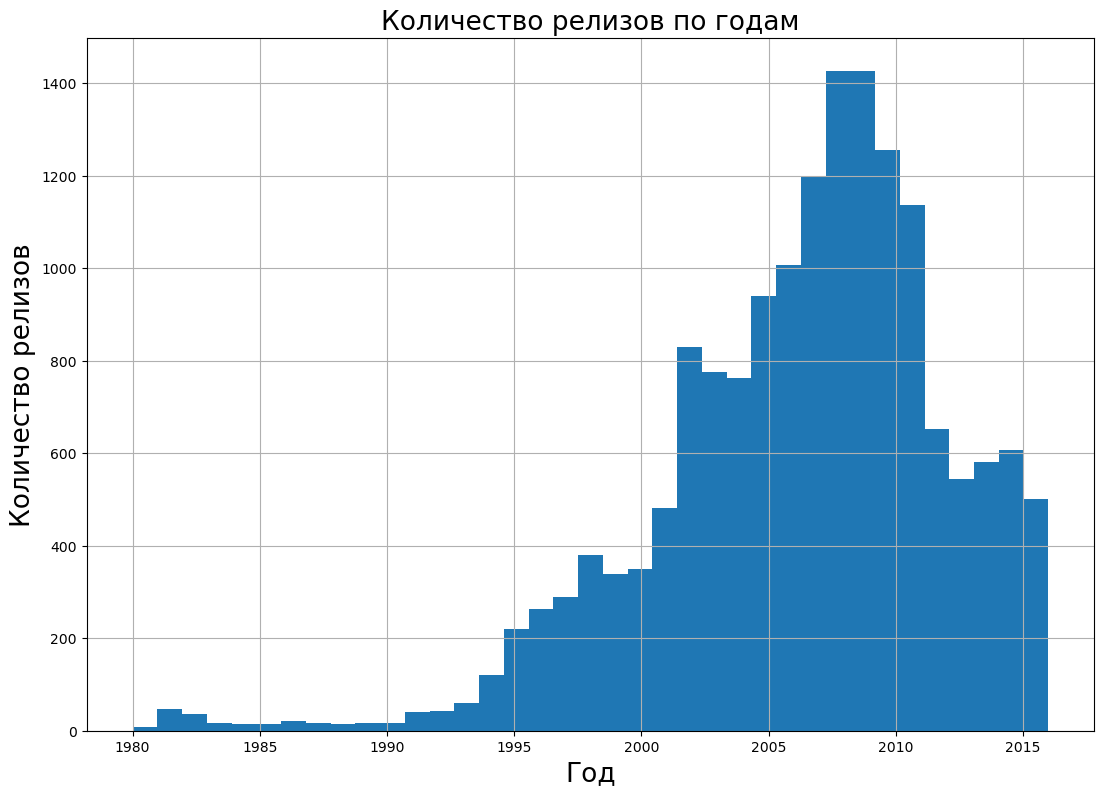

In [23]:
df['year_of_release'].hist(bins=37, figsize=(13, 9))
plt.title('Количество релизов по годам', size=19)
plt.xlabel('Год', size=19)
plt.ylabel('Количество релизов', size=19)
plt.show()

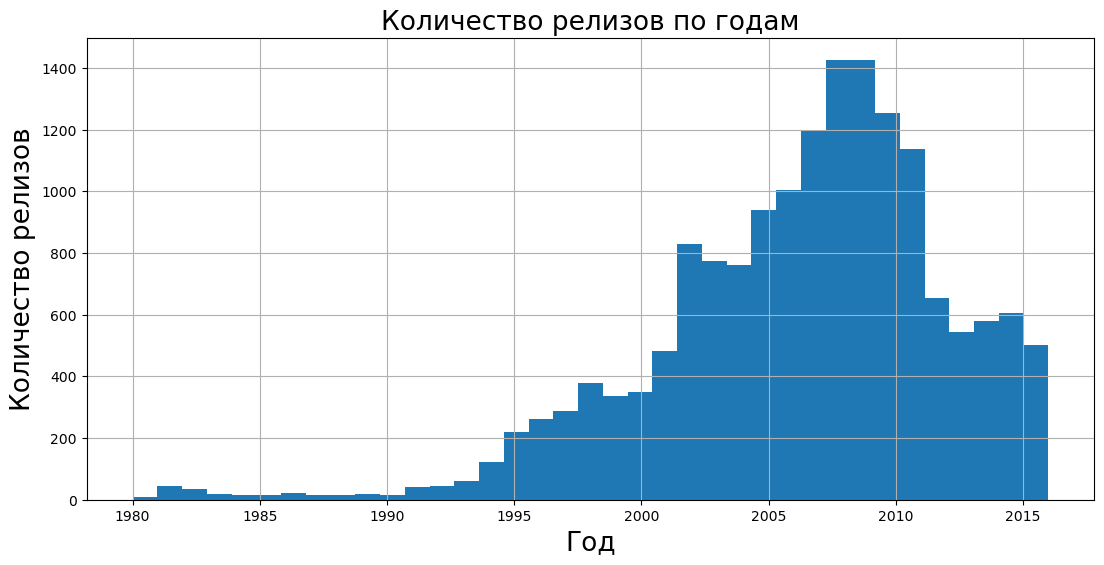

In [24]:
# Комментарий ревьюера 2
df['year_of_release'].hist(bins=37, figsize=(13, 6))
plt.title('Количество релизов по годам', size=19)
plt.xlabel('Год', size=19)
plt.ylabel('Количество релизов', size=19)
plt.show()

На графике видно, что начиная с 1995 года количество новых релизов начало резко возрастать каждые пять лет до 2010, после этого года произошёл резкий спад количества релизов, в 2016 году произошёл ещё более резкий скачок (учитывая при этом то, что данные за этот год могут быть не полными). Далее отобразим эту закономерность.

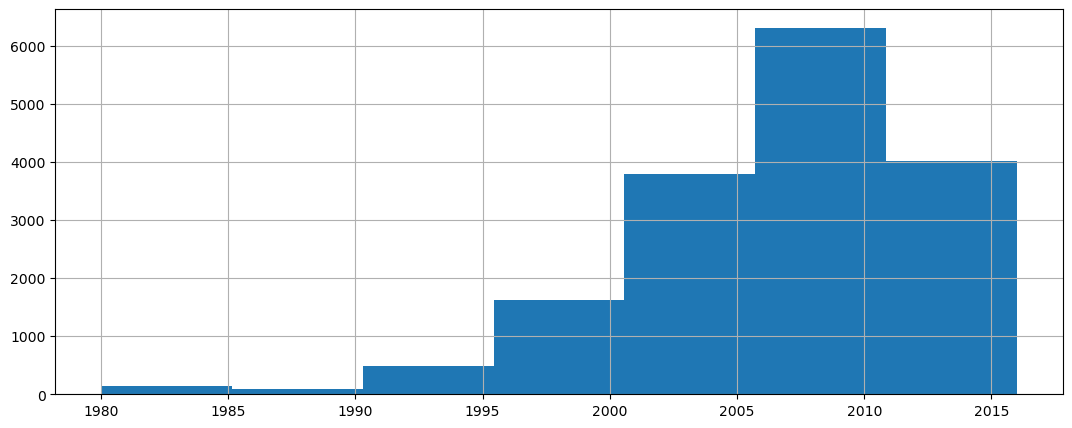

In [25]:
df['year_of_release'].hist(bins=7, figsize=(13, 5))
plt.show()

Теперь определим, на какие платформы выходит больше всего сумма продаж релизов. 

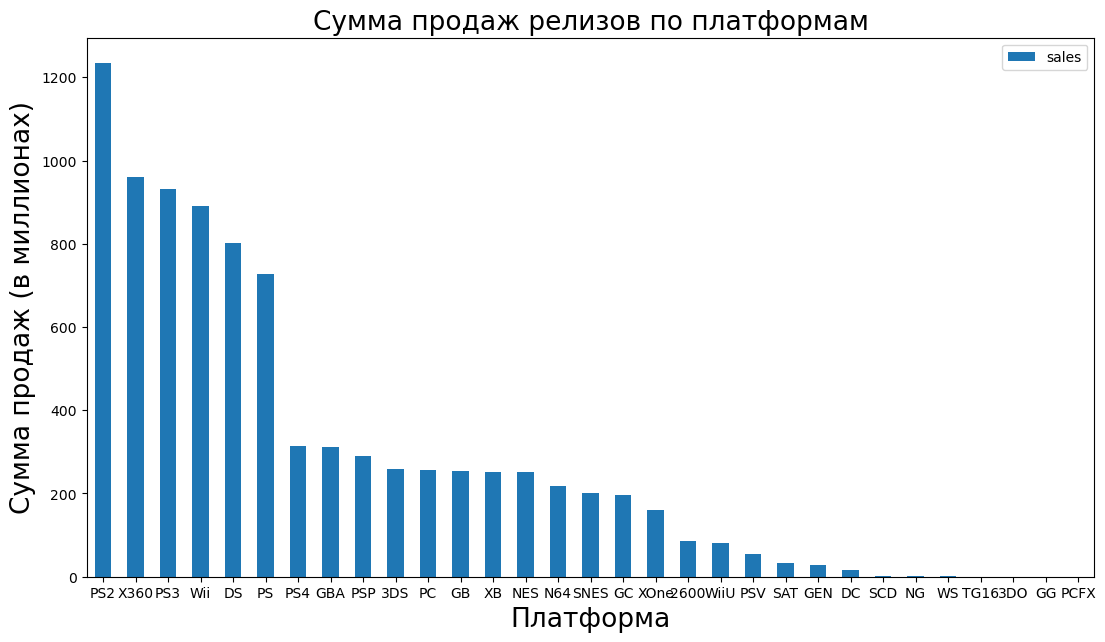

In [26]:
platform_sales = df.pivot_table(index='platform', values='sales', aggfunc='sum')
platform_sales.sort_values(by='sales', ascending=False, inplace=True)
platform_sales.plot.bar(figsize=(13, 7), rot=0)
plt.title('Сумма продаж релизов по платформам', size=19)
plt.xlabel('Платформа', size=19)
plt.ylabel('Сумма продаж (в миллионах)', size=19)
plt.show()

Мы видим, что наибольшие суммарные продажи игр приходятся на следующие платформы:
- PS2
- X360
- PS3
- Wii
- DS
- PS

Посмотрим, как менялись продажи суммы продаж релизов на эти платформы по годам. Создадим функцию `sales_per_year_for_platform`, которая будет строить гистограмму для суммарных продаж игр на определённую платформу по годам.

In [27]:
def sales_per_year_for_platform(platform_name):
    df_for_hist = df.query('platform == @platform_name').pivot_table(index='year_of_release', 
                                   values='sales', aggfunc='sum').reset_index()
    df_for_hist.plot.bar(x='year_of_release', y='sales', figsize=(13, 7), rot=0)
    temp = 'Распределение суммарных продаж релизов по годам для платформы' + ' ' + platform_name
    plt.title(temp, size=15)
    plt.xlabel('Год',size=17)
    plt.ylabel('Сумма продаж (в миллионах)',size=17)
    plt.show()

Теперь по очереди отобразим суммарные продажи релизов по годам для платформ.

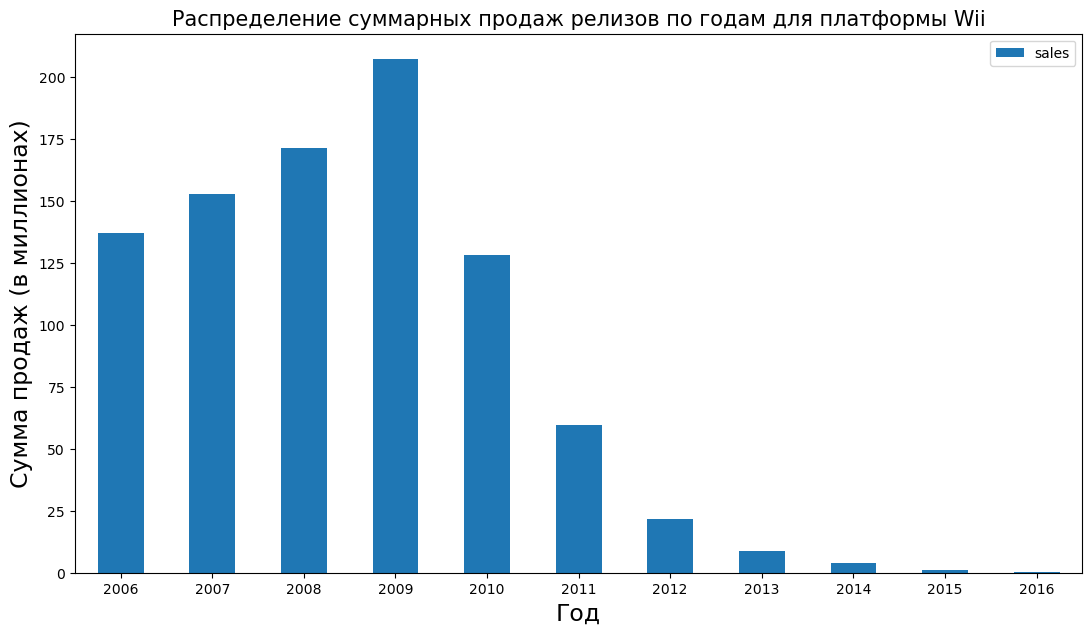

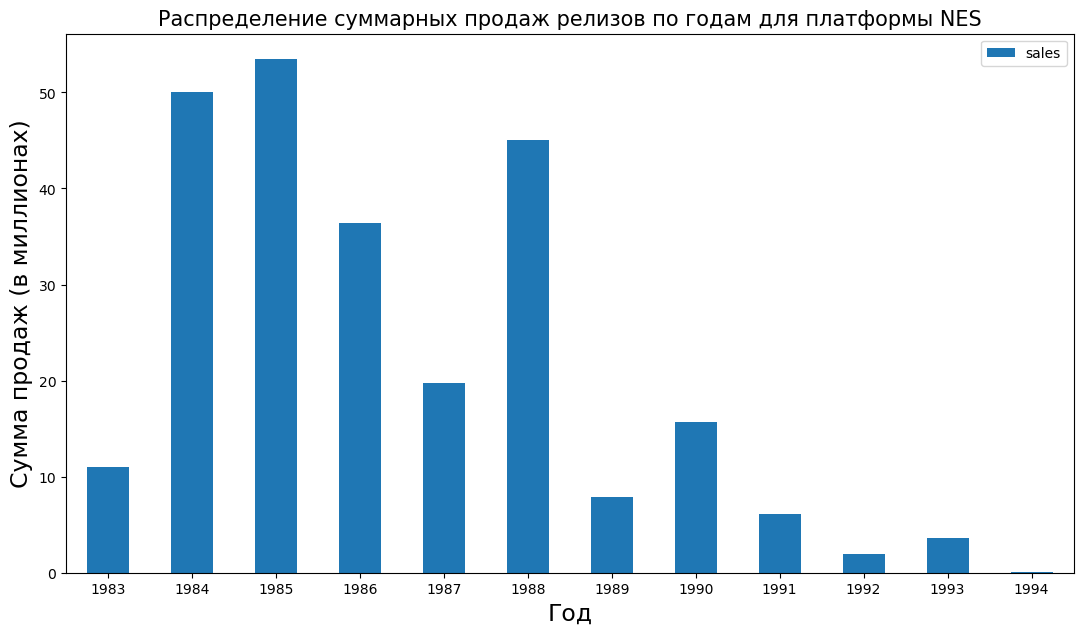

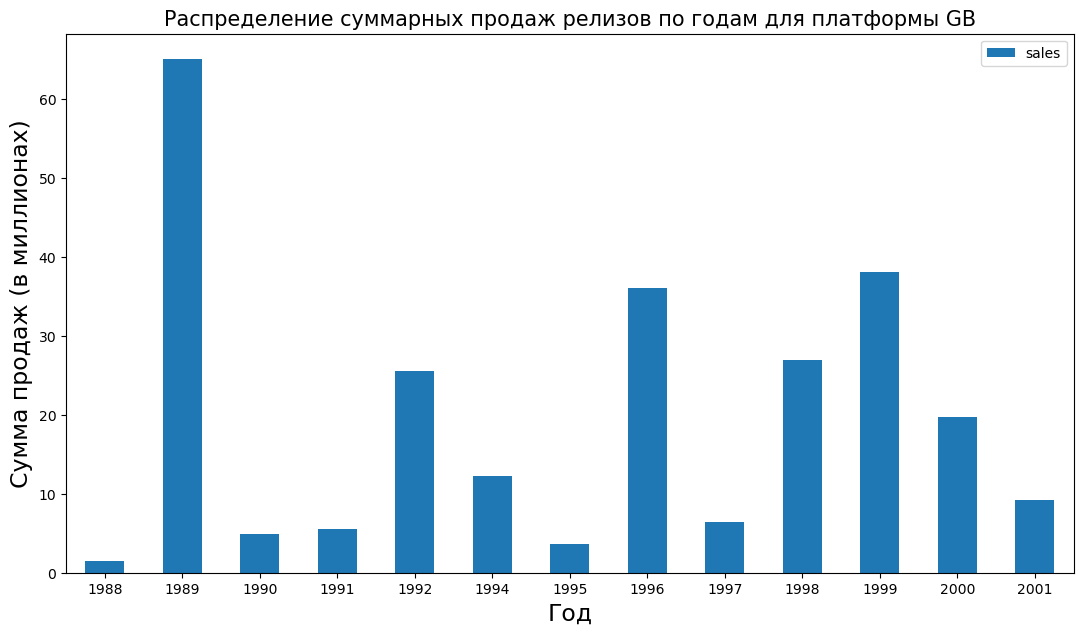

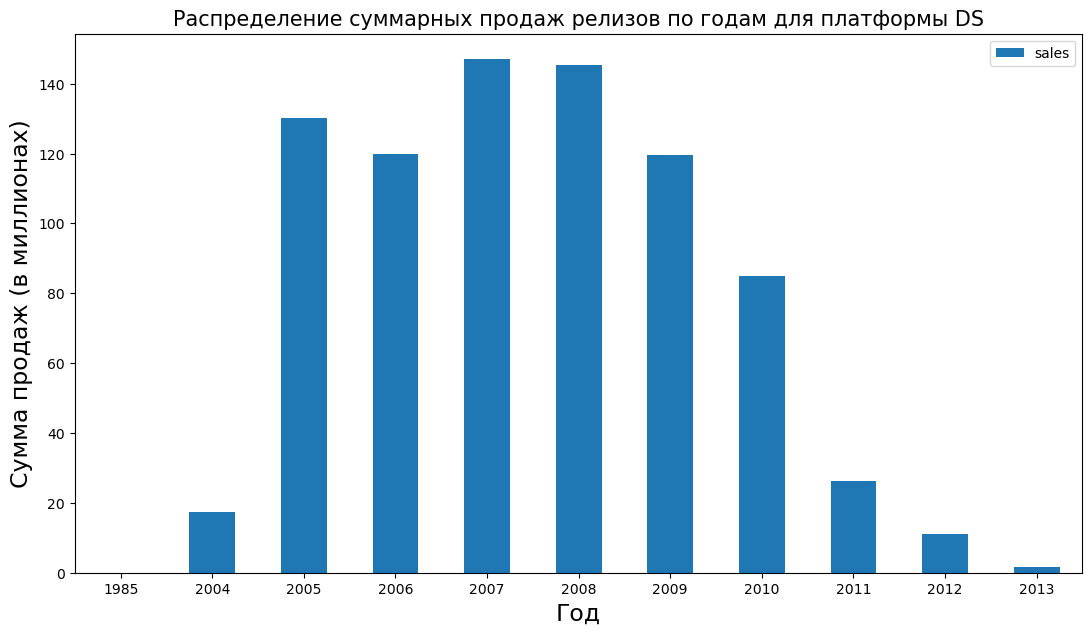

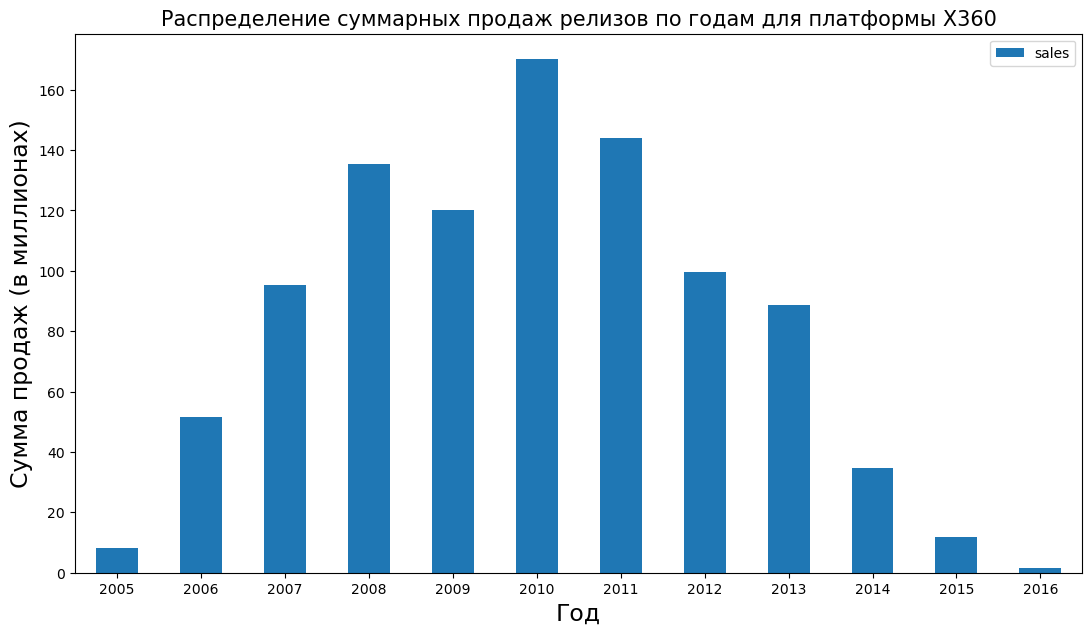

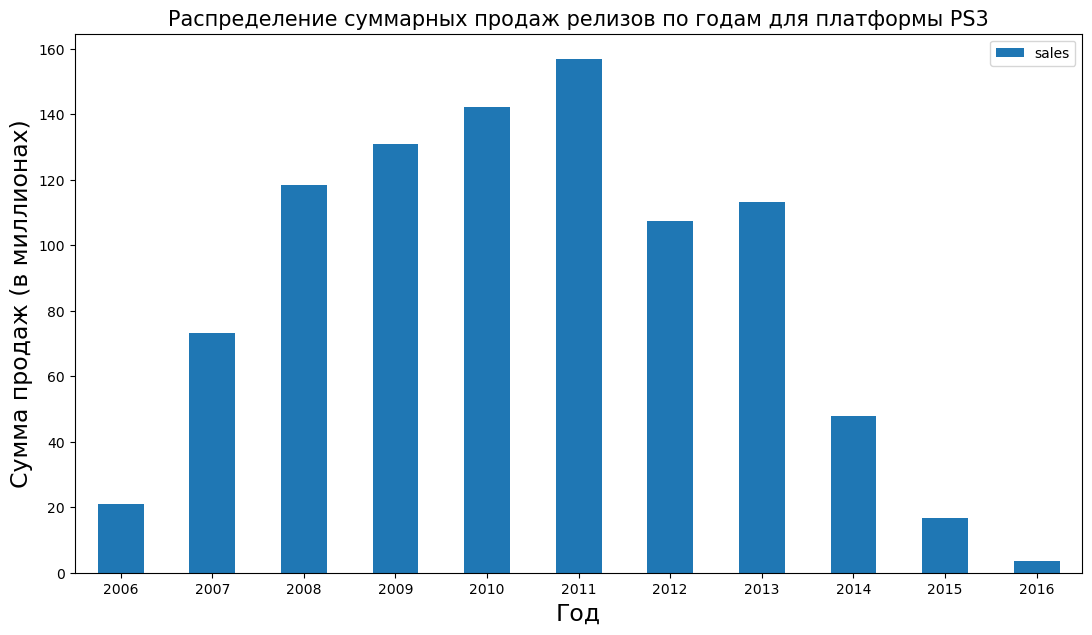

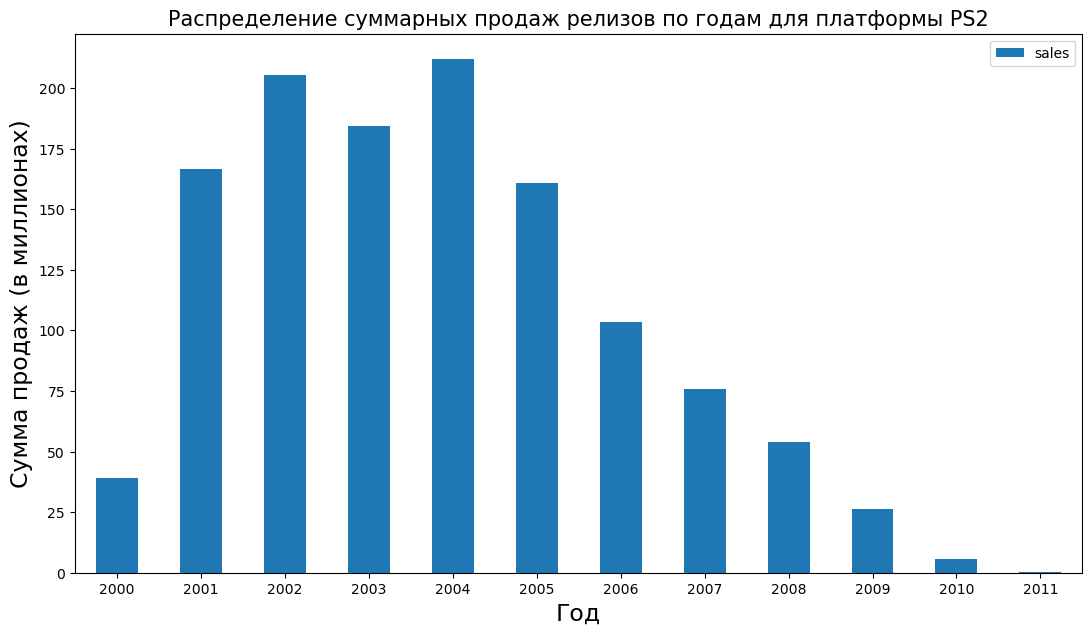

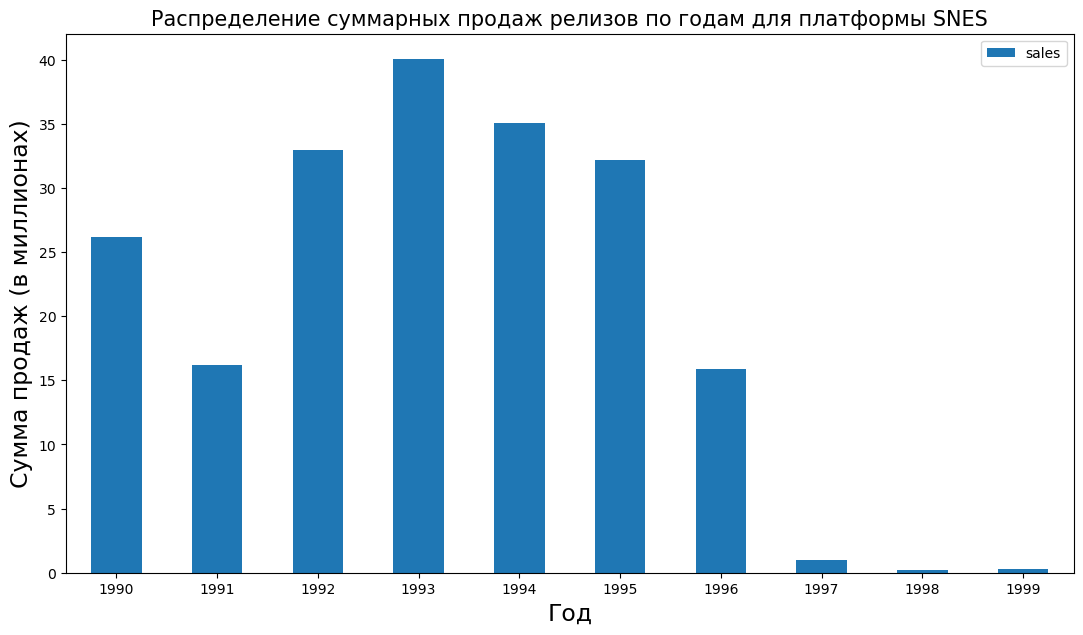

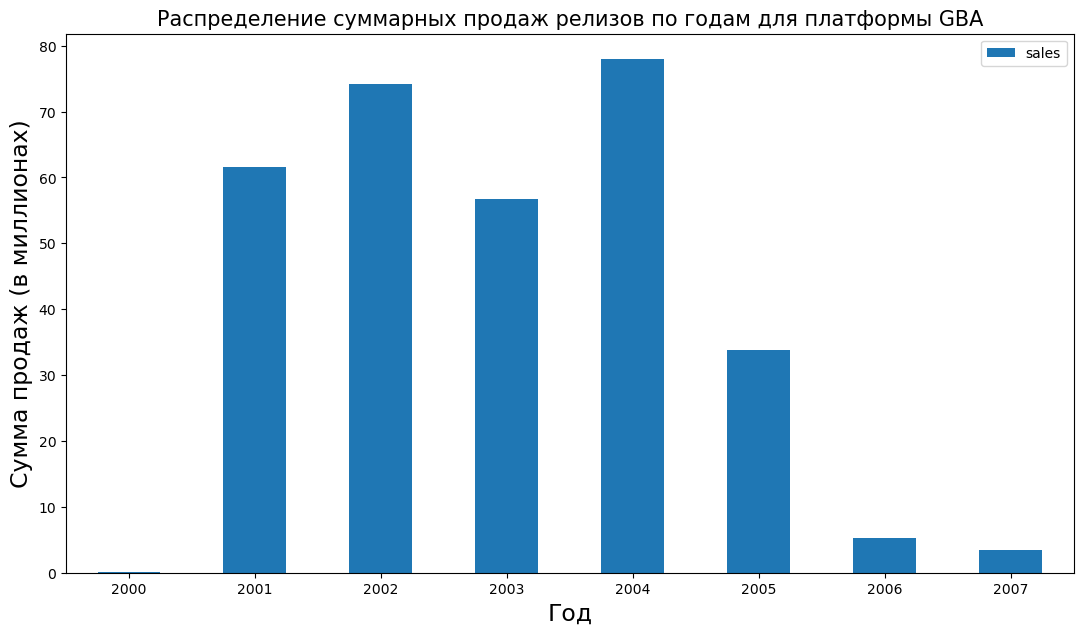

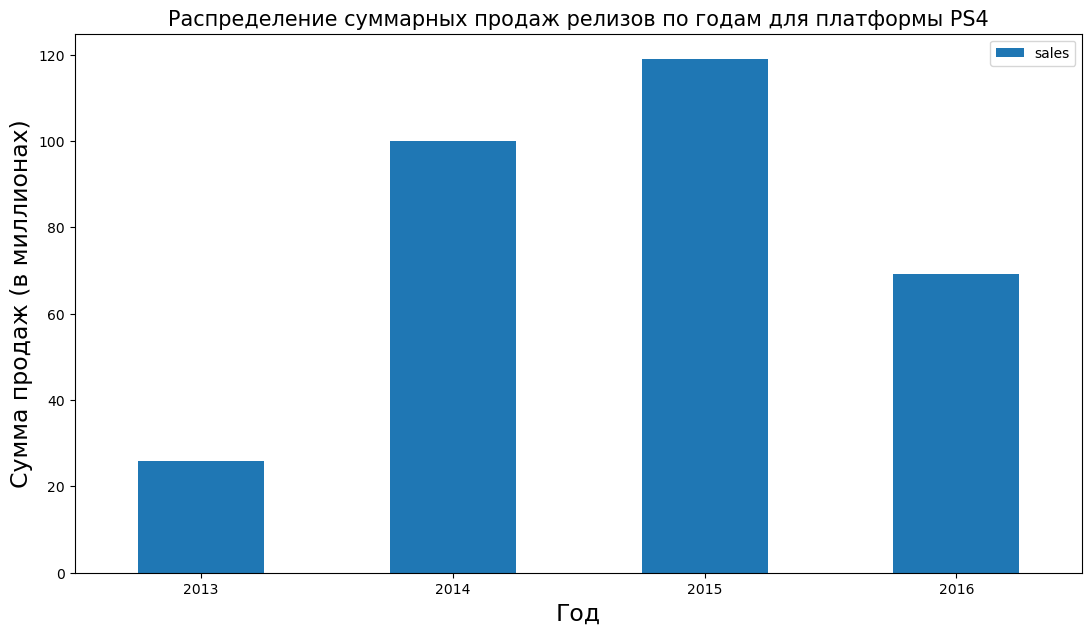

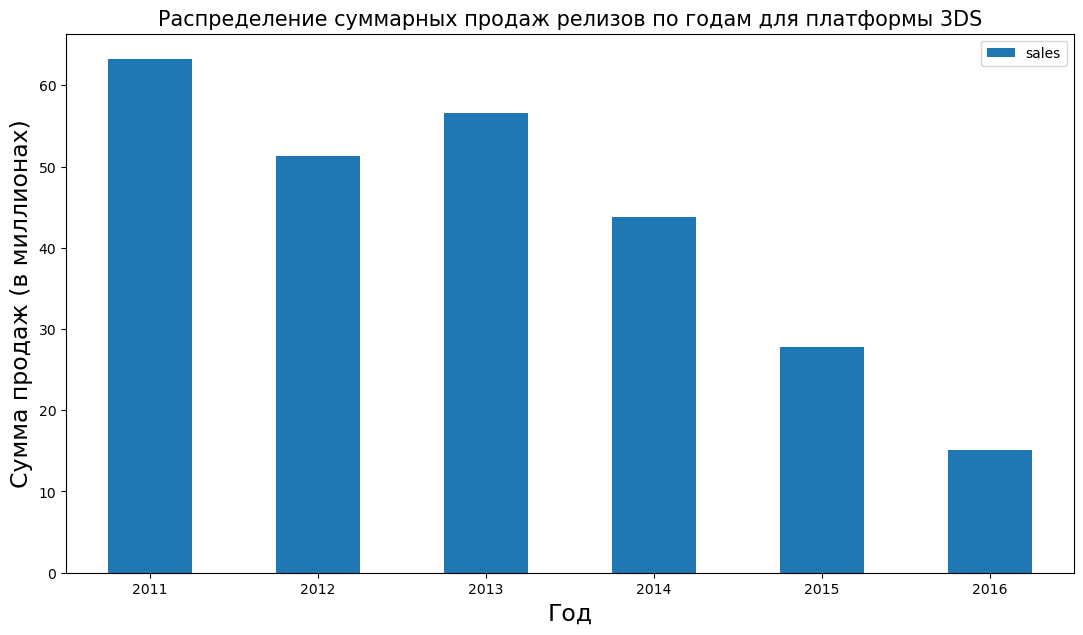

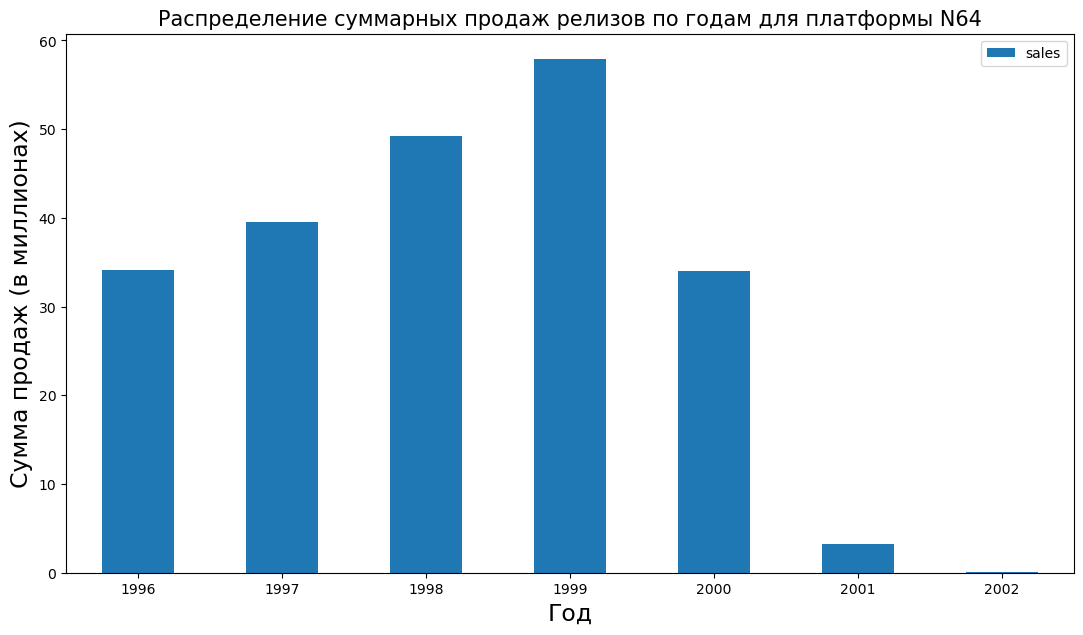

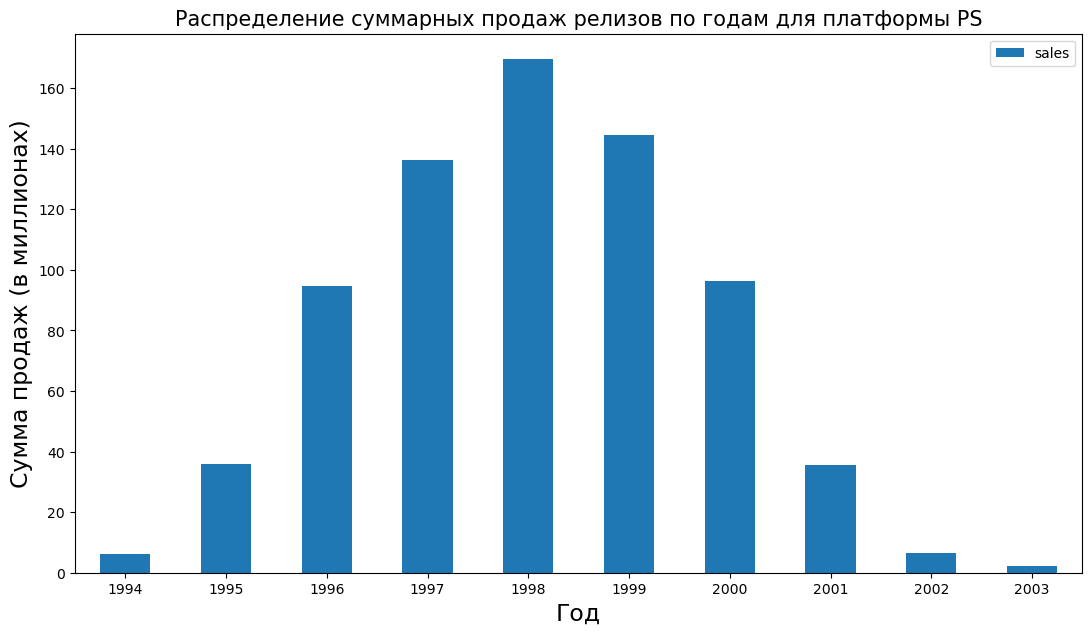

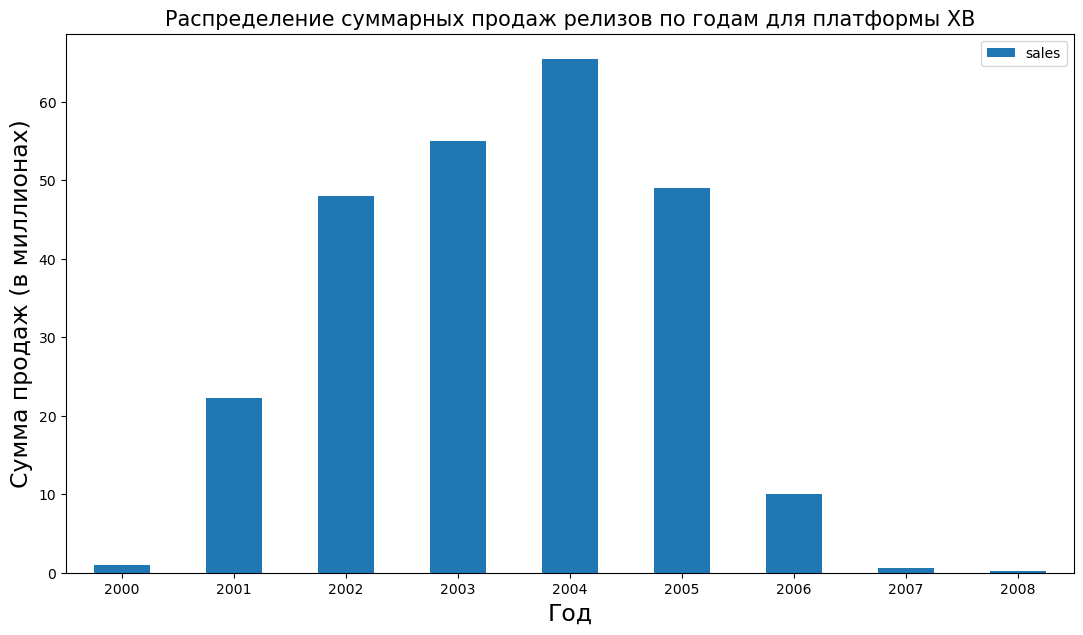

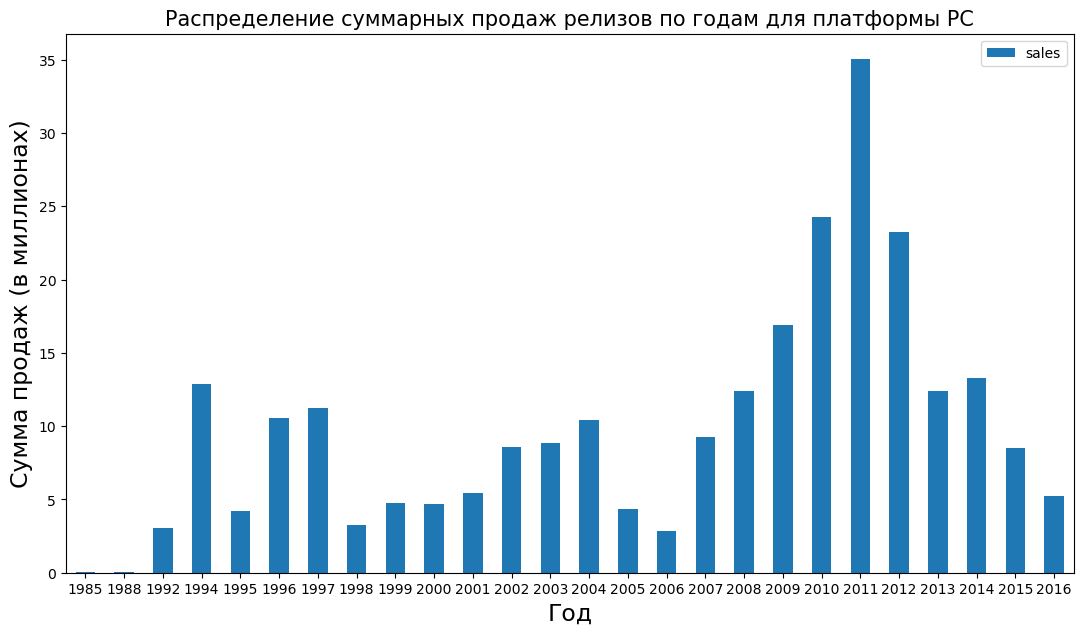

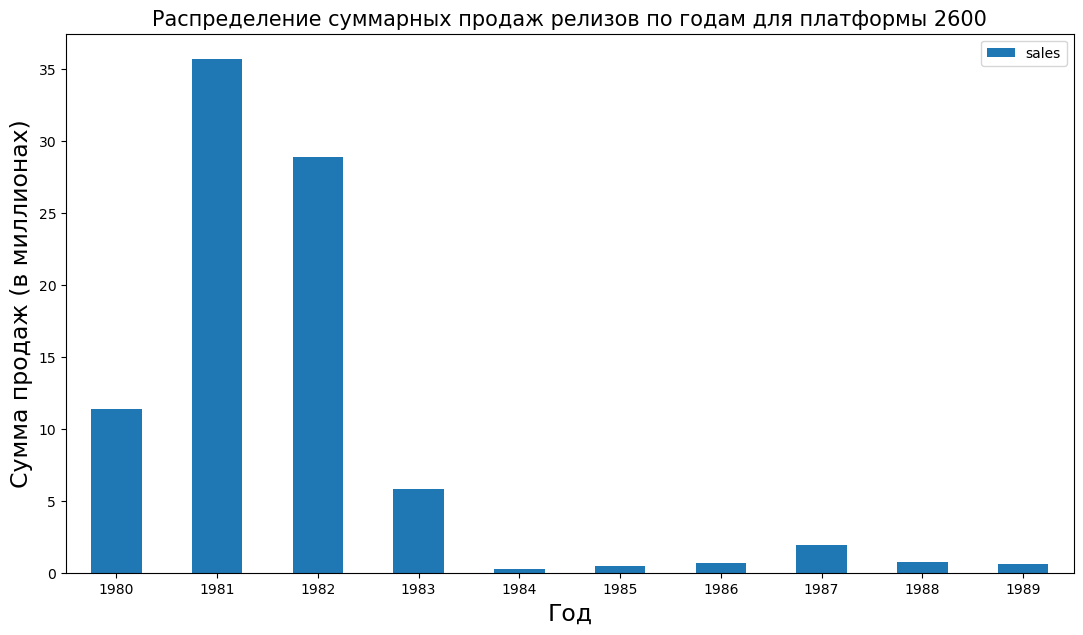

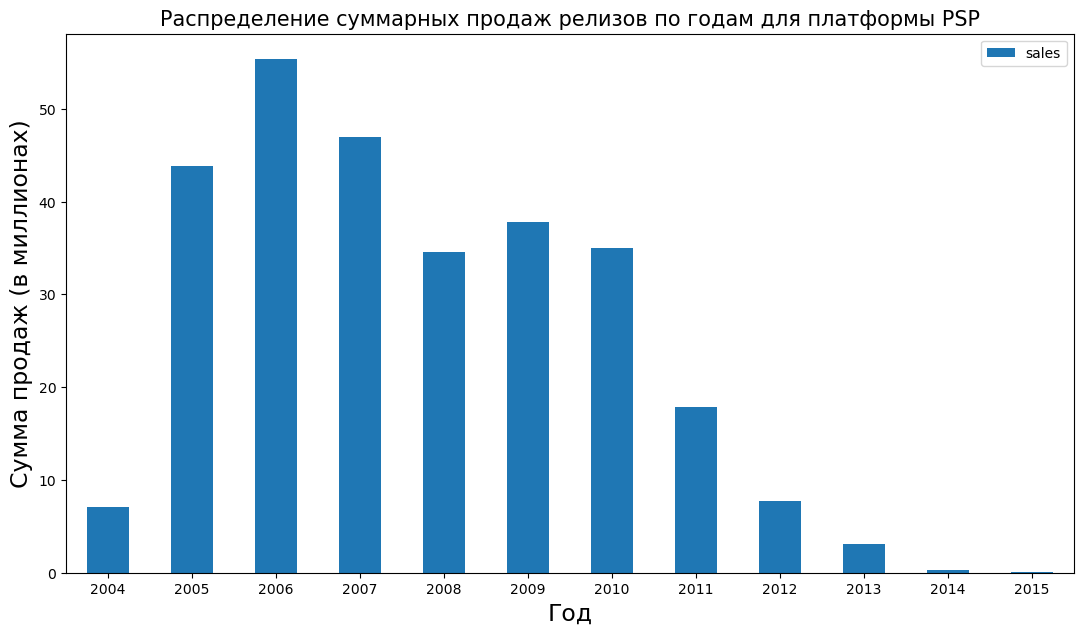

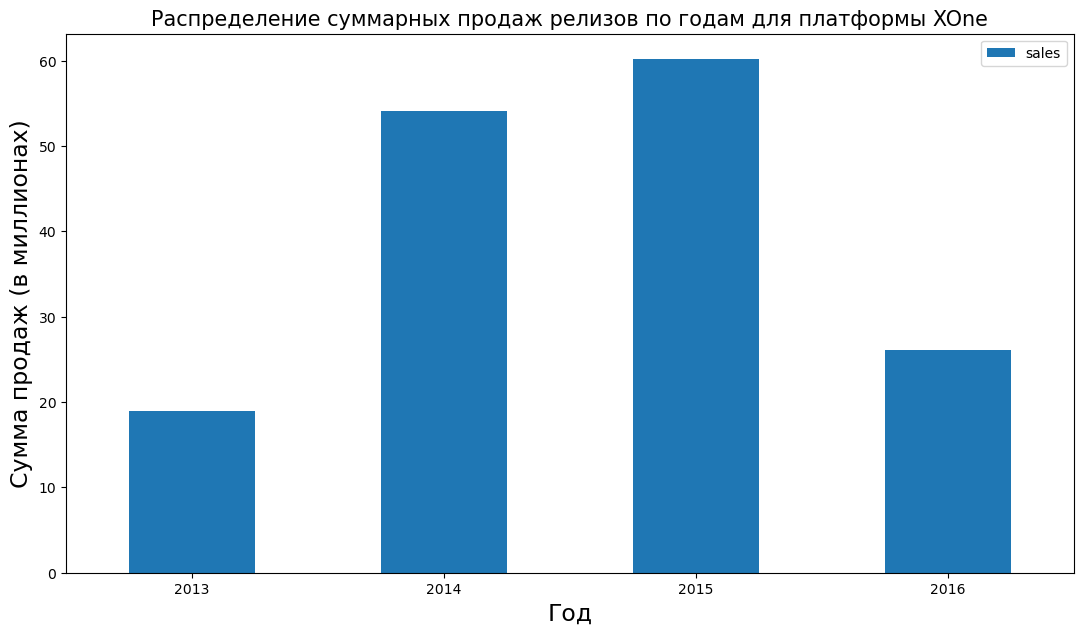

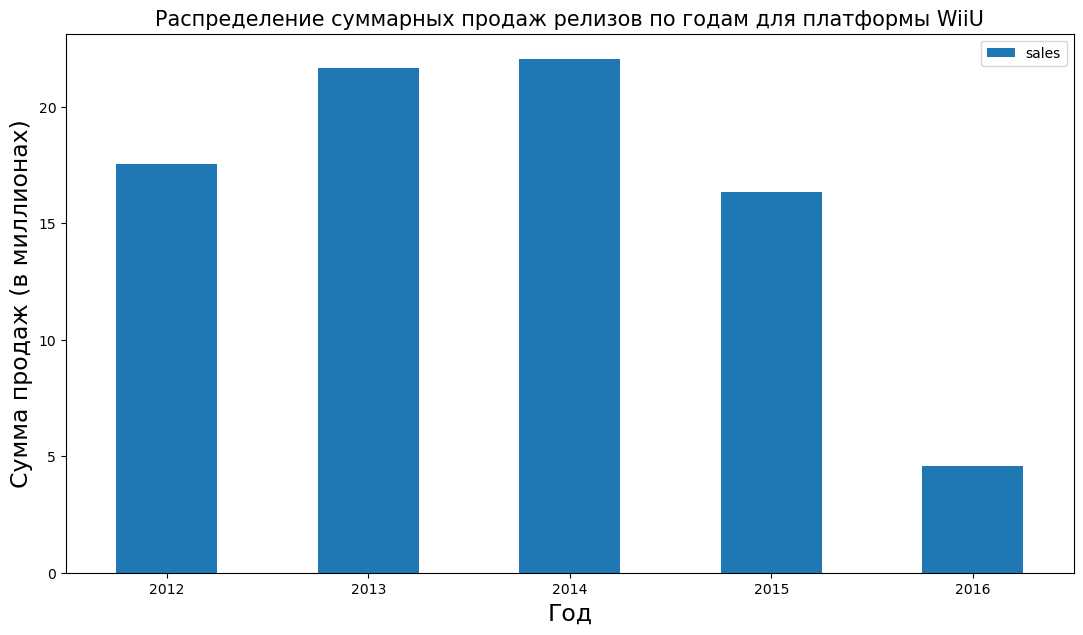

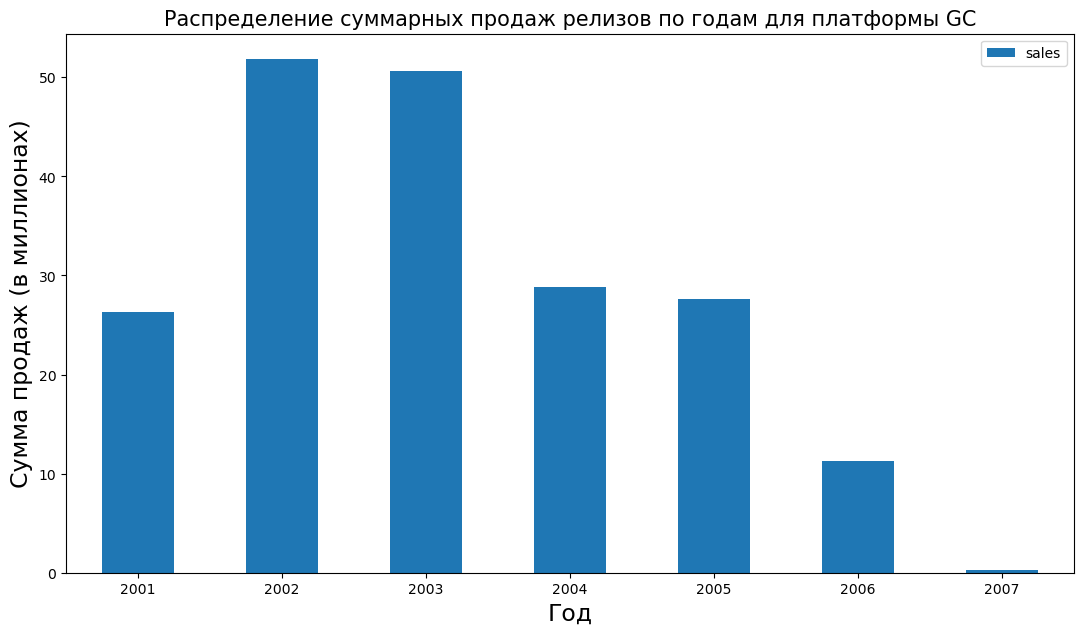

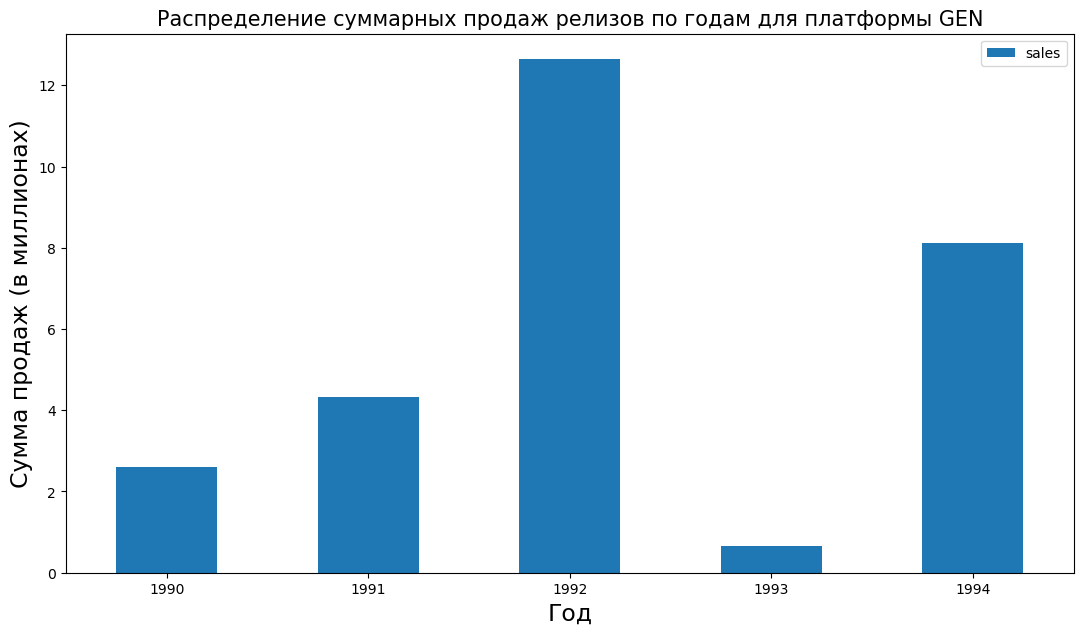

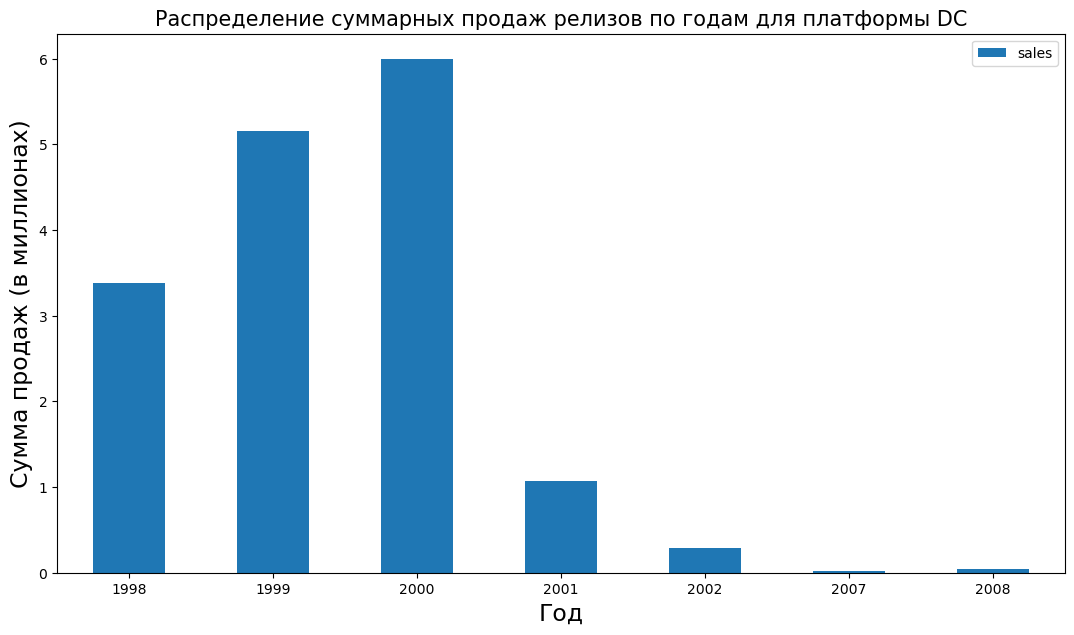

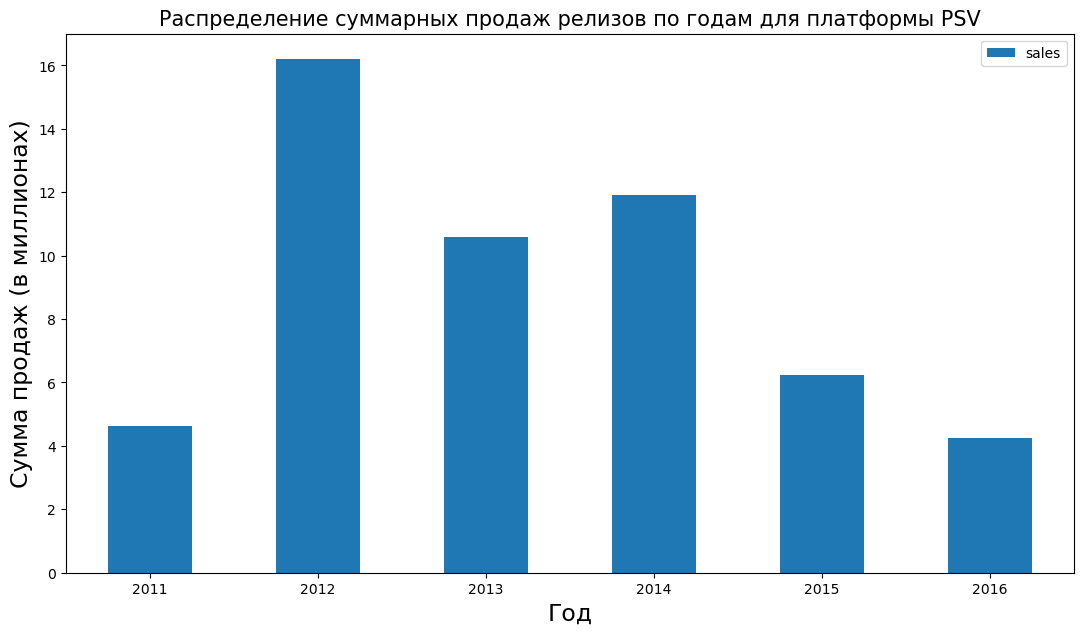

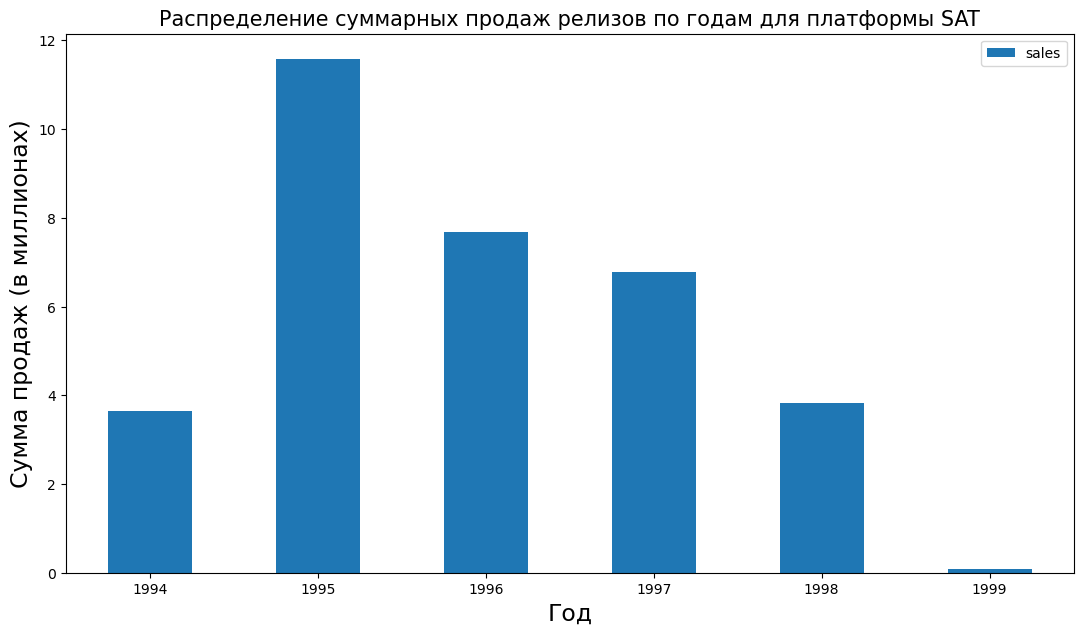

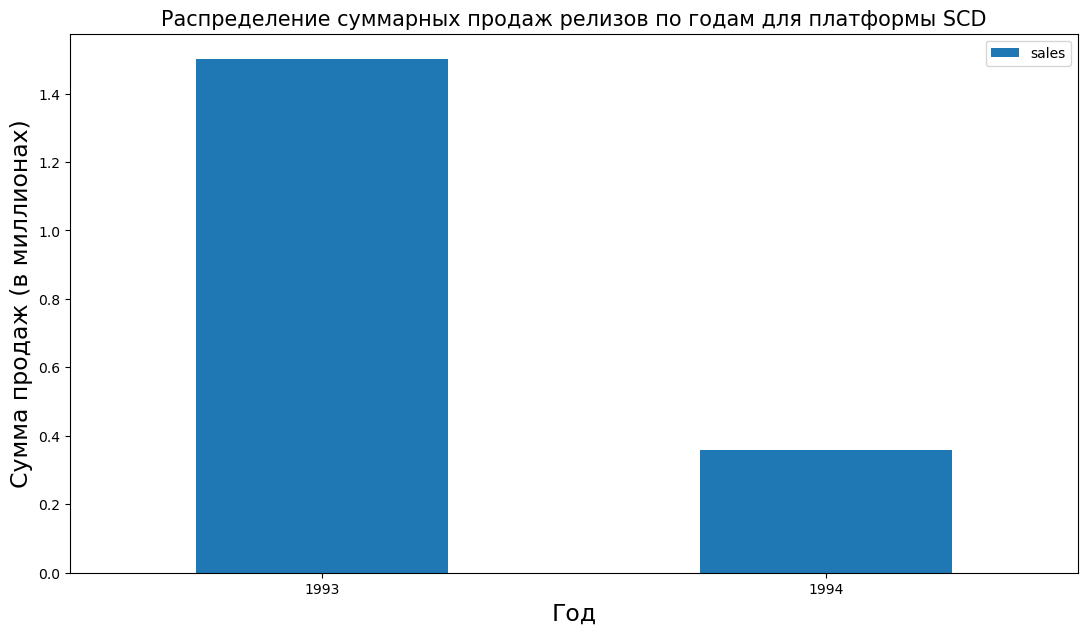

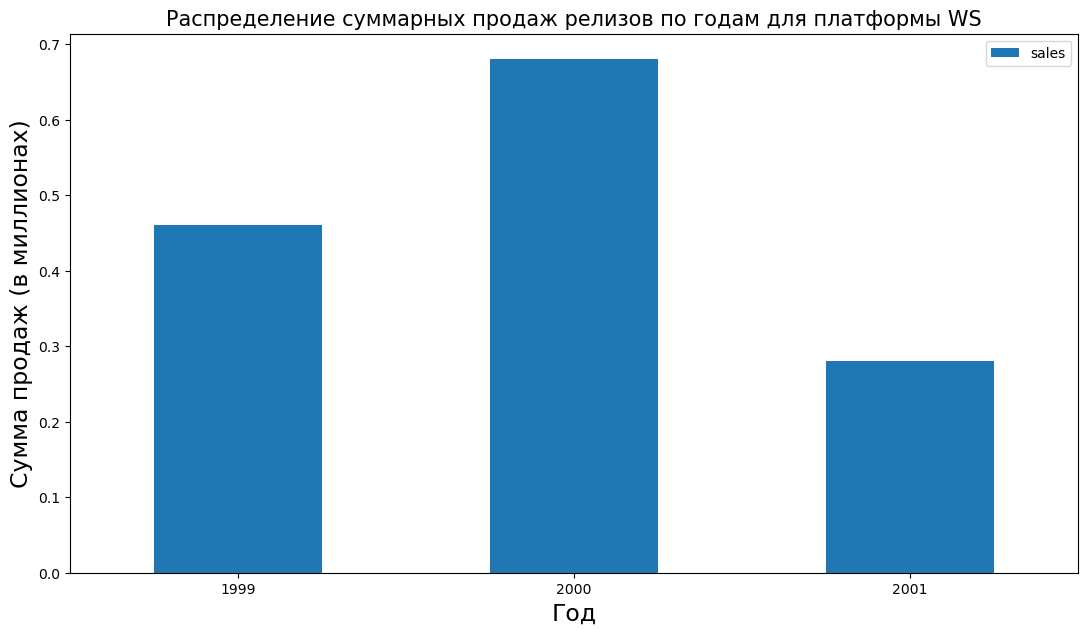

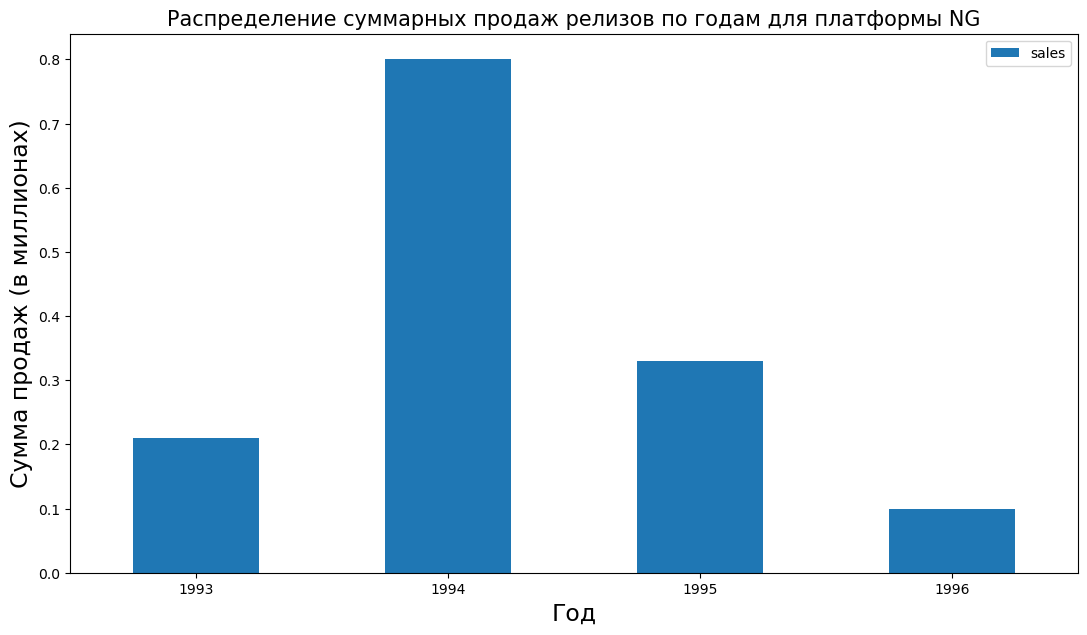

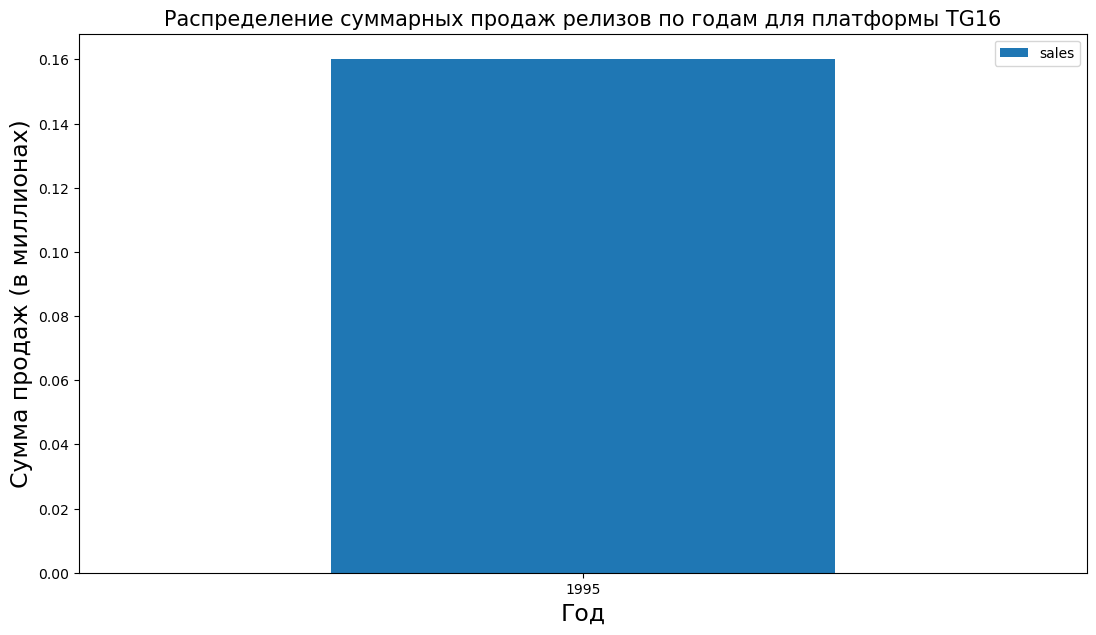

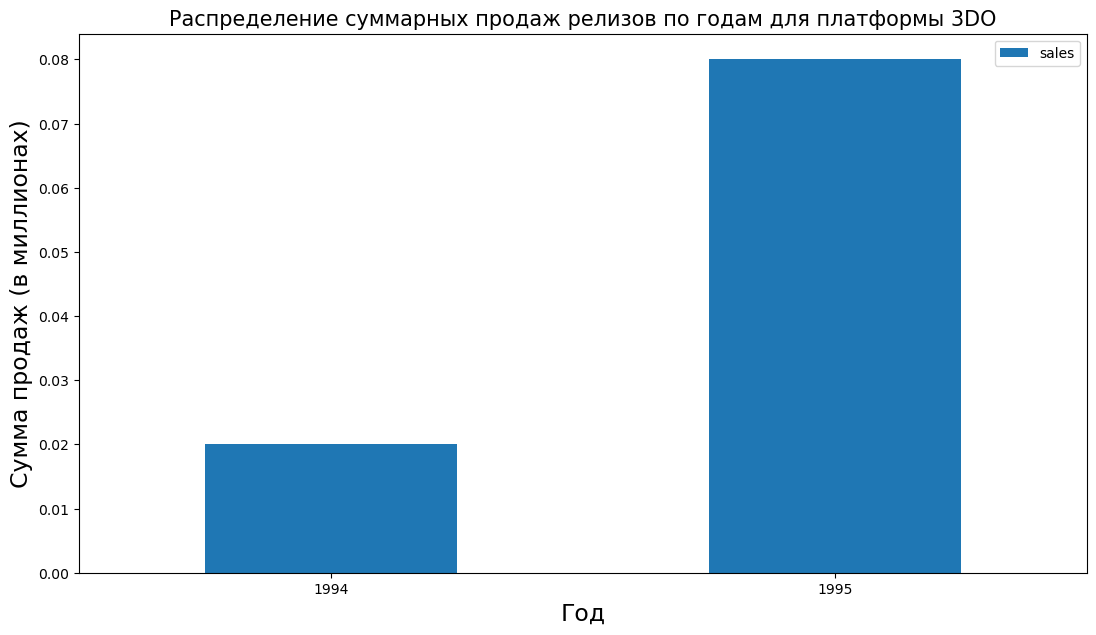

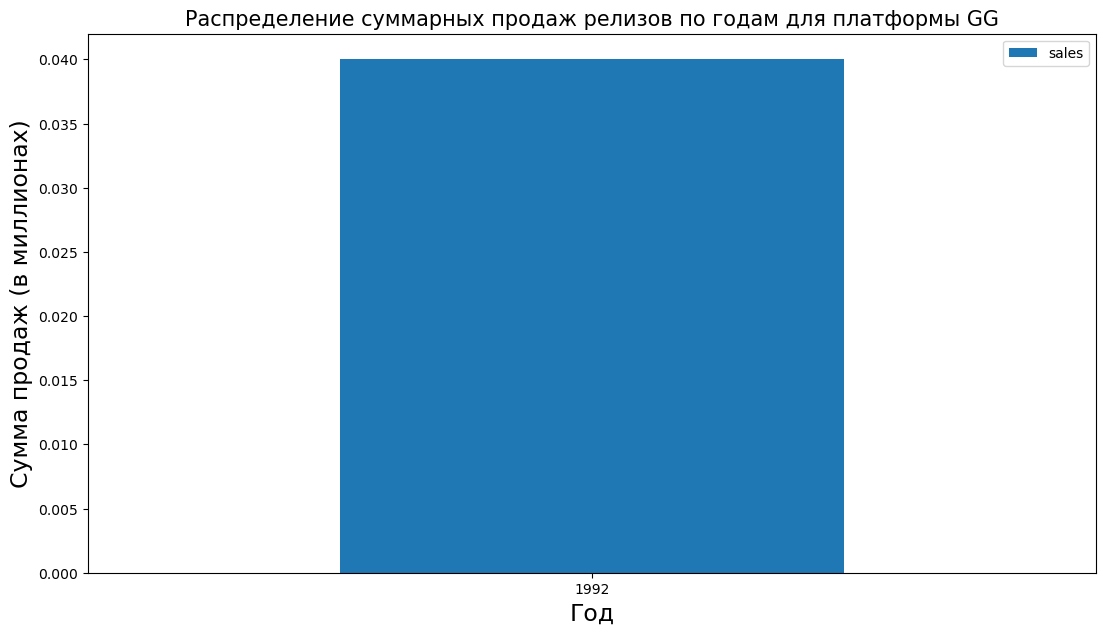

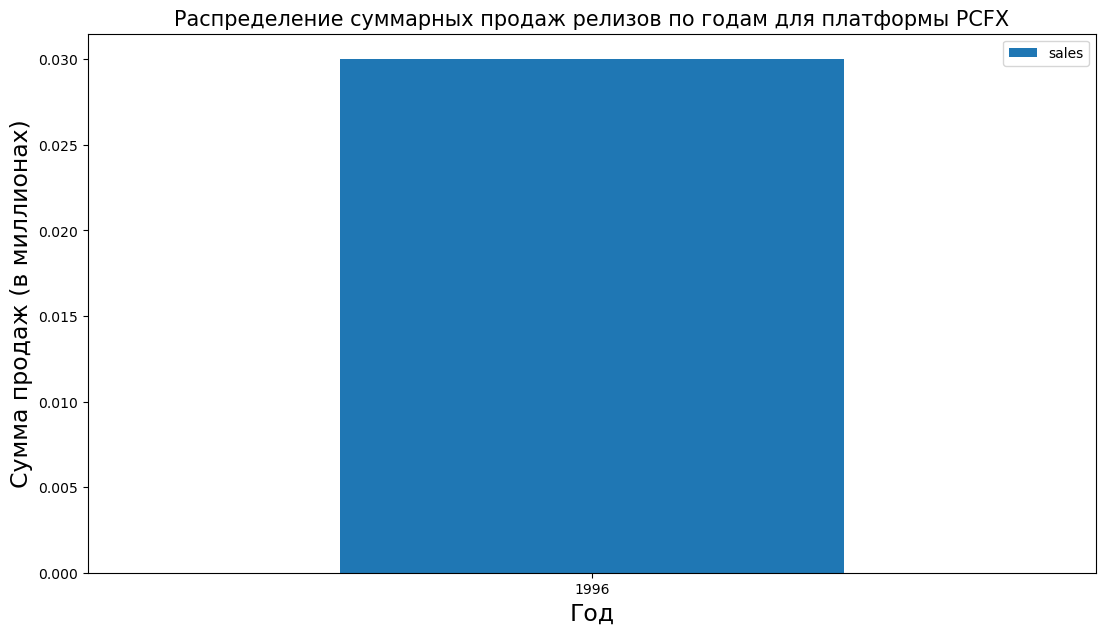

In [28]:
platforms = df['platform'].unique()

for platform in platforms:
    sales_per_year_for_platform(platform)

Из полученных данных по сумме продаж релизов игр на определённы платформы по годам можно сделать следующие выводы:
- Сумма продаж релизов игр на старые платформы падает из года в год (исключение PC).
- Вместе с тем сумма продаж релизов игр на новые платформы растёт.
- Самая прибыльная платформа за всё время по известным нам данным PS2, после неё X360.
- В среднем платформы "живут" 6-9 лет.

Актуальный период возьмём 3 года (включая 2016), исходя из следующих соображения о том, что игровая индустрия очень динамично меняющийся бизнес. А также суммы продаж релизов растут только на новые платформы. Не будем брать временной период больше, так как мы будем рисковать захватить уже отжившие тренды. 

Посмотрим какие платформы растут в актуальный для нас период.

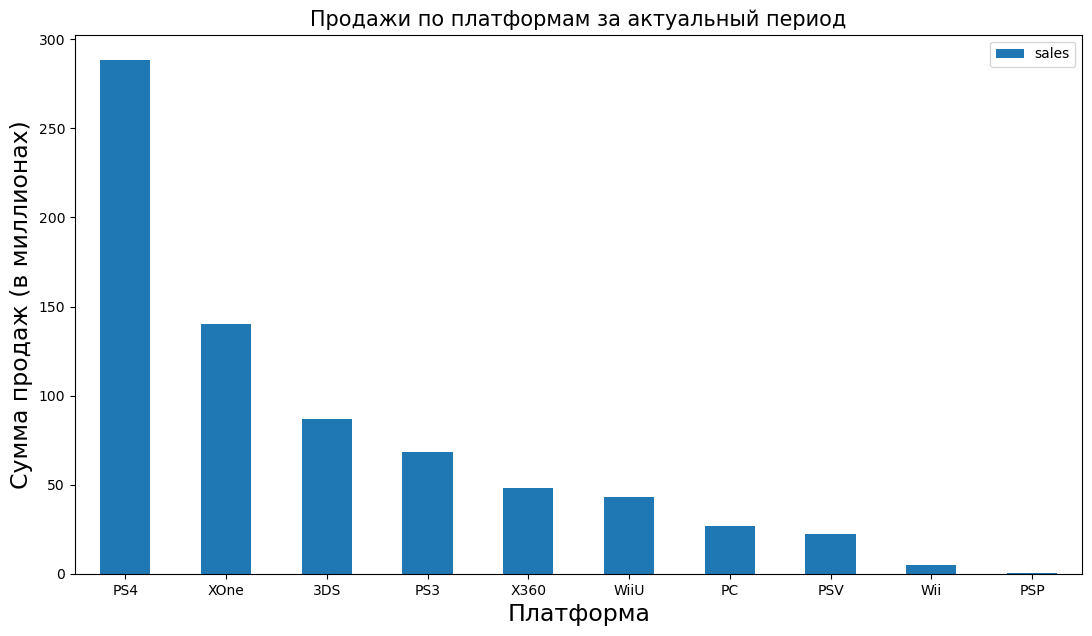

In [29]:
actual_df = df.query('year_of_release > 2013')
actual_df_platform = actual_df.pivot_table(index='platform', values='sales', aggfunc='sum').reset_index()
actual_df_platform.sort_values(by='sales', ascending=False, inplace=True)
actual_df_platform.plot.bar(x='platform', y='sales', figsize=(13, 7), rot=0)
plt.title('Продажи по платформам за актуальный период', size=15)
plt.xlabel('Платформа',size=17)
plt.ylabel('Сумма продаж (в миллионах)',size=17)
plt.show()

Мы видим что в актуальный для нашего исследования период самыми успешными платформами являются PS4, а за ней с существенным отставанием XOne, 3DS, PS3 и X360.

Теперь построим диаграммы размаха по глобальным продажам в разбивке по платформам чтобы оценить на каких платформах больше выбросов.

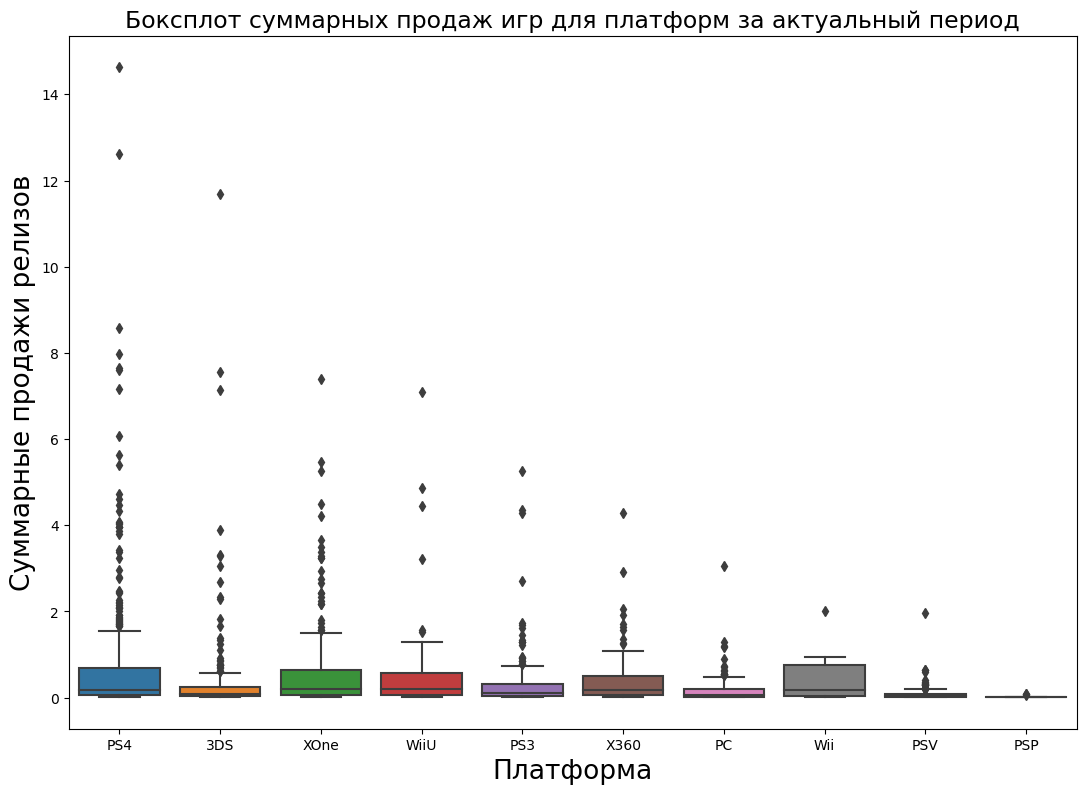

In [30]:
plt.figure(figsize=(13,9))
sb.boxplot(data=actual_df, x='platform', y='sales')
plt.title('Боксплот суммарных продаж игр для платформ за актуальный период', size=17)
plt.xlabel('Платформа', fontsize=19)
plt.ylabel('Суммарные продажи релизов',fontsize=19)
plt.show()

На графике видно "частые" и "редкие" выбросы, которые связаны, вероятно с играми-хитами, которые увеличили суммарные продажи релизов. Больше всего хитов на PS4, 3DS, XOne и WiiU.

Для наглядности масштабируем наш боксплот.

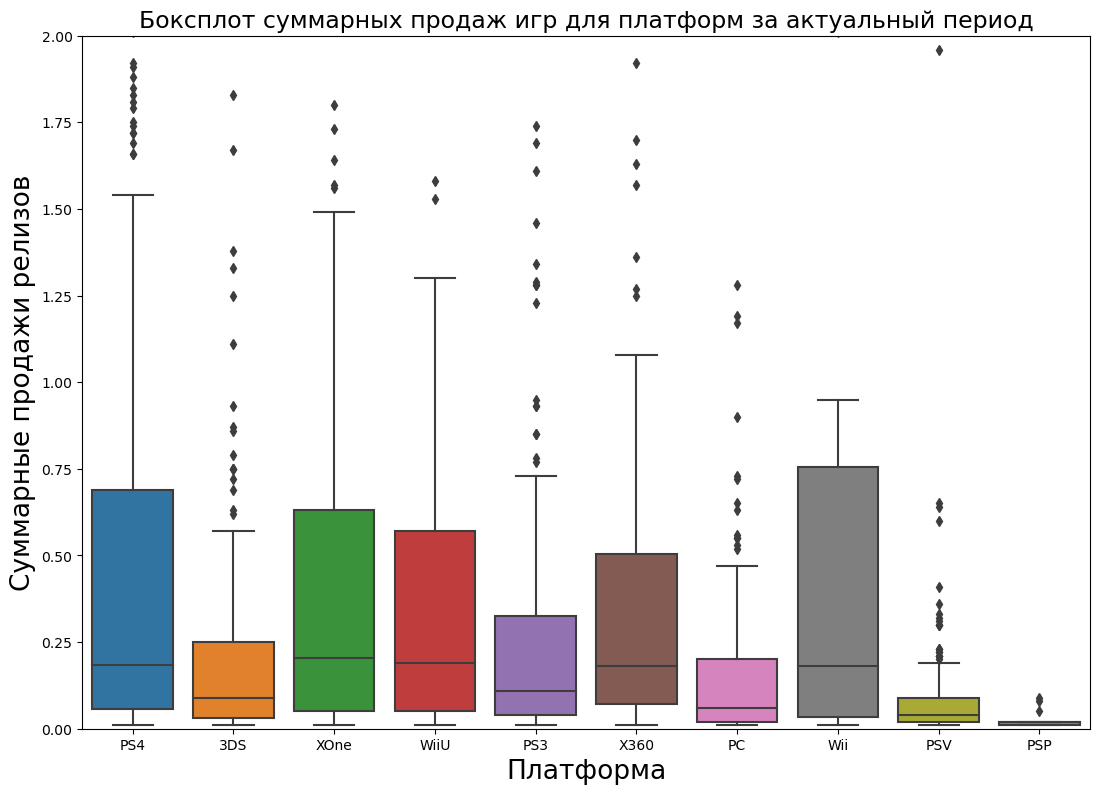

In [31]:
plt.figure(figsize=(13,9))
sb.boxplot(data=actual_df, x='platform', y='sales')
plt.title('Боксплот суммарных продаж игр для платформ за актуальный период', size=17)
plt.ylim(bottom=0, top=2)
plt.xlabel('Платформа', fontsize=19)
plt.ylabel('Суммарные продажи релизов',fontsize=19)
plt.show()

Теперь посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Для этого построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Для построения возьмём все значения, а не только за актуальный период, поскольку корреляция между оценками и суммарными продажами релиза игры не должна менятся со временем и так у нас будет больше данных. Отбросим значения-заглушки, чтобы они не влияли на значение корреляции.

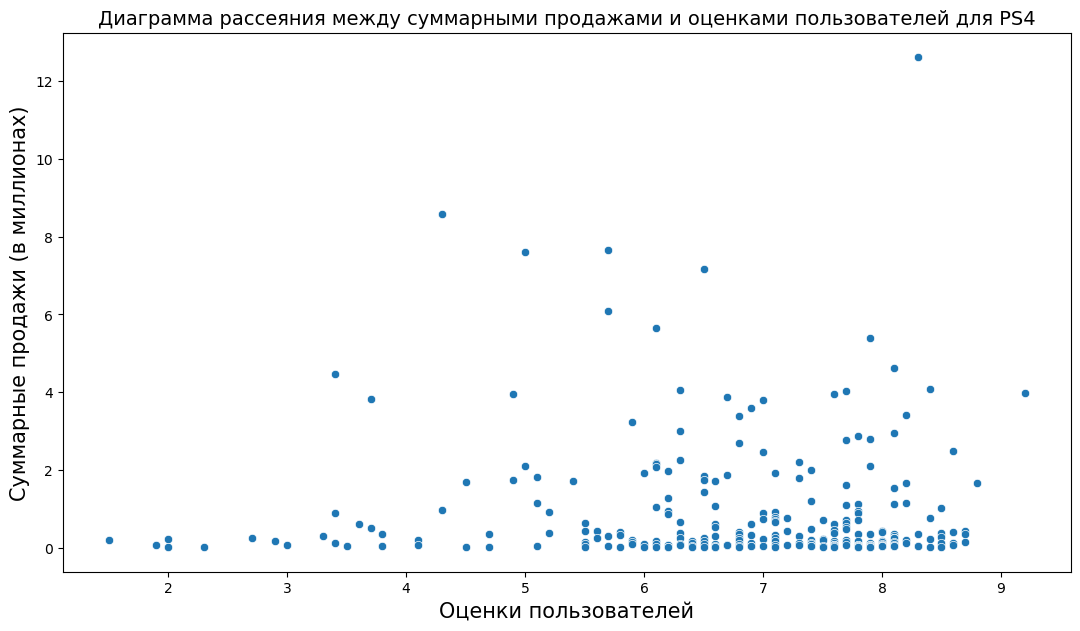

Корреляция суммарных продаж с оценкой пользователей: -0.031957110204556424


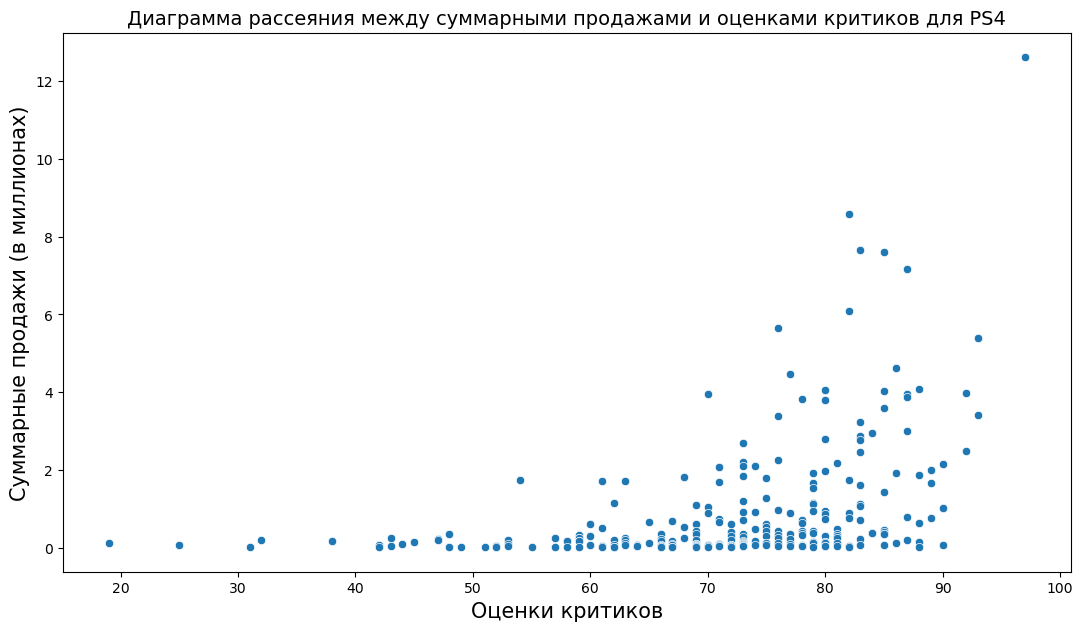

Корреляция суммарных продаж с оценкой критиков: 0.40656790206178095


In [32]:
ps4_df = df[df['platform'] == 'PS4'].query('user_score >= 0')

plt.figure(figsize=(13, 7))
sb.scatterplot(data=ps4_df, x='user_score', y='sales')
plt.title('Диаграмма рассеяния между суммарными продажами и оценками пользователей для PS4', size=14)
plt.xlabel('Оценки пользователей', size=15)
plt.ylabel('Суммарные продажи (в миллионах)', size=15)
plt.show()
print('Корреляция суммарных продаж с оценкой пользователей:', ps4_df['user_score'].corr(ps4_df['sales']))

ps4_df = df[df['platform'] == 'PS4'].query('critic_score >= 0')
plt.figure(figsize=(13, 7))
sb.scatterplot(data=ps4_df, x='critic_score', y='sales')
plt.title('Диаграмма рассеяния между суммарными продажами и оценками критиков для PS4', size=14)
plt.xlabel('Оценки критиков', size=15)
plt.ylabel('Суммарные продажи (в миллионах)', size=15)
plt.show()
print('Корреляция суммарных продаж с оценкой критиков:', ps4_df['critic_score'].corr(ps4_df['sales']))

Мы видим, что корреляция между суммарными продажами и оценками пользователей очень низкая и отрицательная.
Корреляция же между суммарными продажами и оценками критиков слабая положительная (чуть больше 0.4).
Соотнесём выводы с продажами игр на других актуальных платформах. Для этого создадим функцию `corr_for_actual_platforms` и применим её ко всем актуальным на данный период платформам.

In [33]:
#Функция, которая построит диаграммы рассеивания и определит корреляции
def corr_for_actual_platforms(platform_name):
#Создаю переменную, в которой хранится датафрейм соответсвует условиям условиям:
#1-название платформы соответсвует заданному в аргументе функции
#2-Оценки пользователей больше или равны нулю (чтобы отсеить заглушки)
    df_for_hist = df[df['platform'] == platform_name]
    df_for_hist = df_for_hist.query('user_score >= 0')
    #df_for_hist = df.query('platform == @platform_name and user_score >=0').pivot_table(
                #index=['user_score'], values='sales', aggfunc='sum').reset_index()
    
#Строю график для оценок пользователей
    plt.figure(figsize=(13, 5))
    sb.scatterplot(data=df_for_hist, x='user_score', y='sales')
    temp = 'Диаграмма рассеяния между суммарными продажами и оценками пользователей для платформы' + ' ' + platform_name
    plt.title(temp)
    plt.xlabel('Оценки пользователей', size=17)
    plt.ylabel('Суммарные продажи (в миллионах)', size=13)
    plt.show()
#Вывожу на экран корреляцию оценок с продажами
    print(
        'Корреляция суммарных продаж с оценкой пользователей:', 
        df_for_hist['user_score'].corr(df_for_hist['sales'])
        )

#Создаю переменную, в которой хранится датафрейм соответсвует условиям условиям:
#1-название платформы соответсвует заданному в аргументе функции
#2-Оценки критиков больше или равны нулю (чтобы отсеить заглушки)
    df_for_hist = df[df['platform'] == platform_name]
    df_for_hist = df_for_hist.query('critic_score >= 0')
    
#Строю график для оценок критиков
    plt.figure(figsize=(13, 5))
    sb.scatterplot(data=df_for_hist, x='critic_score', y='sales')
    temp = 'Диаграмма рассеяния между суммарными продажами и оценками критиков для платформы' + ' ' + platform_name
    plt.title(temp)
    plt.xlabel('Оценки критиков', size=17)
    plt.ylabel('Суммарные продажи (в миллионах)', size=13)
    plt.show()
#Вывожу на экран корреляцию оценок с продажами
    print(
        'Корреляция суммарных продаж с оценкой критиков:', 
        df_for_hist['critic_score'].corr(df_for_hist['sales']), '\n', '\n', '\n')

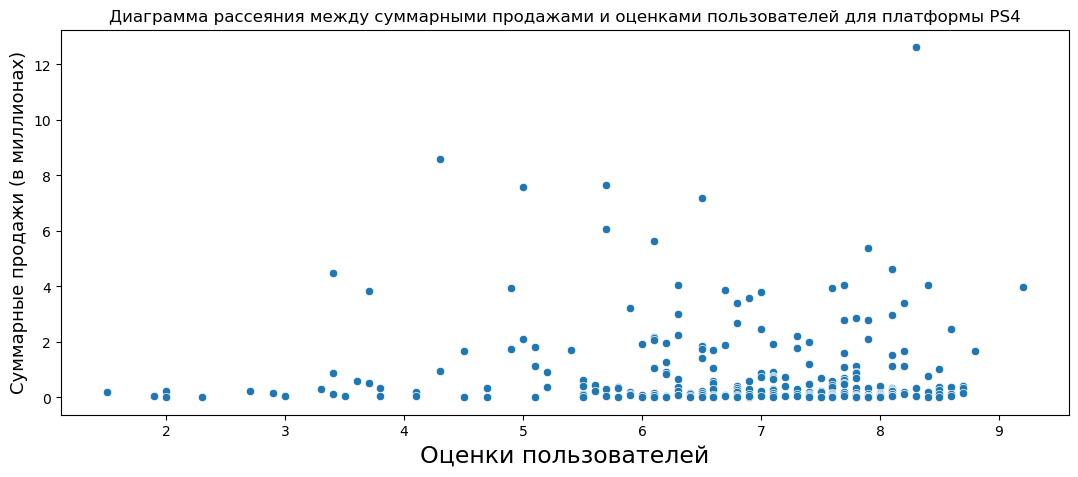

Корреляция суммарных продаж с оценкой пользователей: -0.031957110204556424


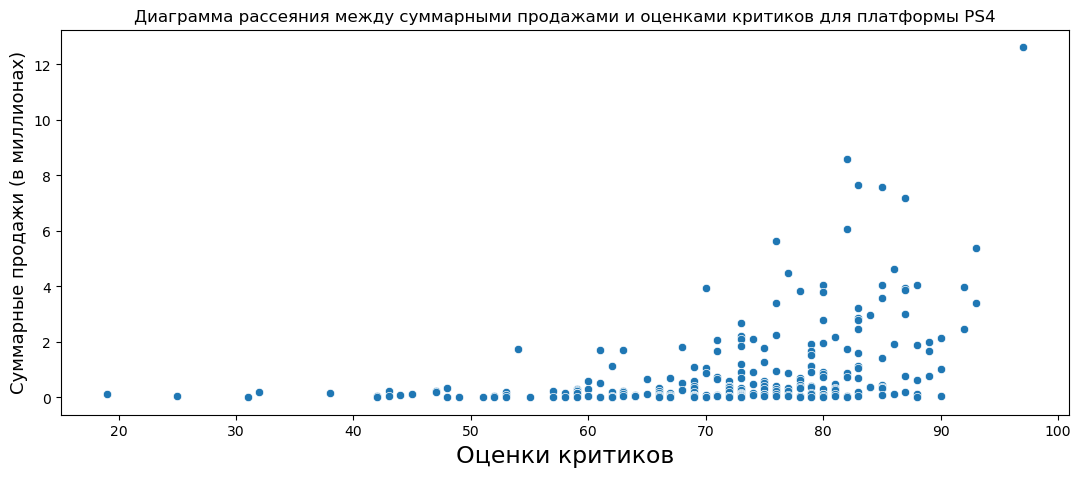

Корреляция суммарных продаж с оценкой критиков: 0.40656790206178095 
 
 



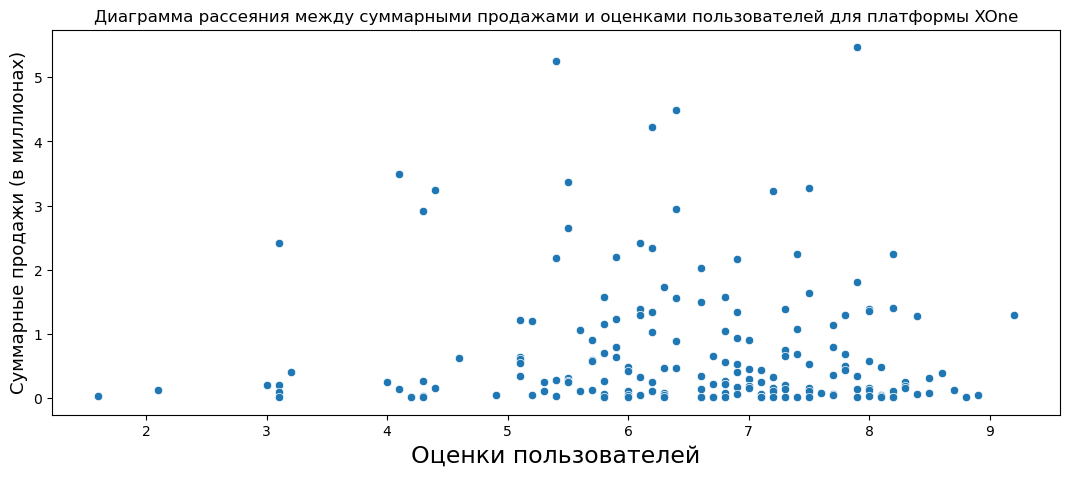

Корреляция суммарных продаж с оценкой пользователей: -0.06892505328279414


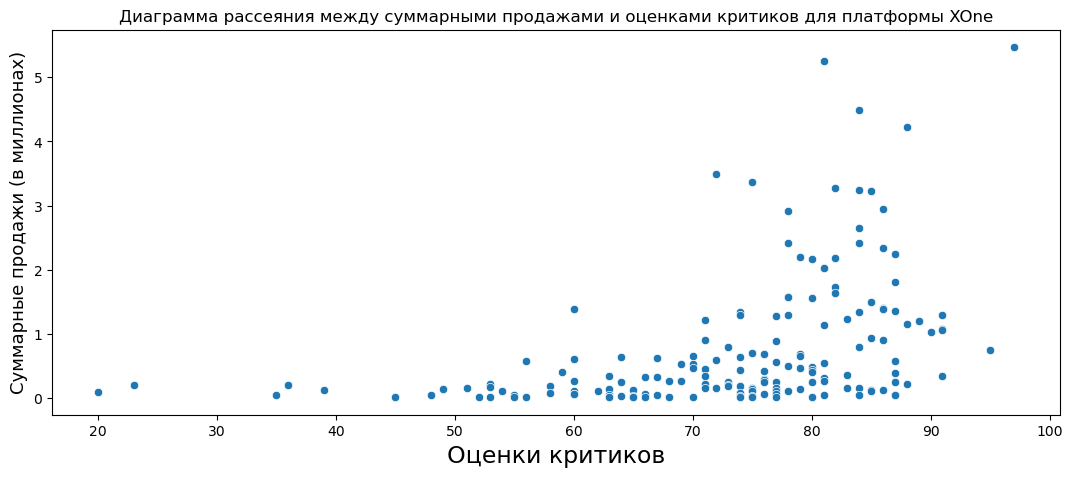

Корреляция суммарных продаж с оценкой критиков: 0.4169983280084017 
 
 



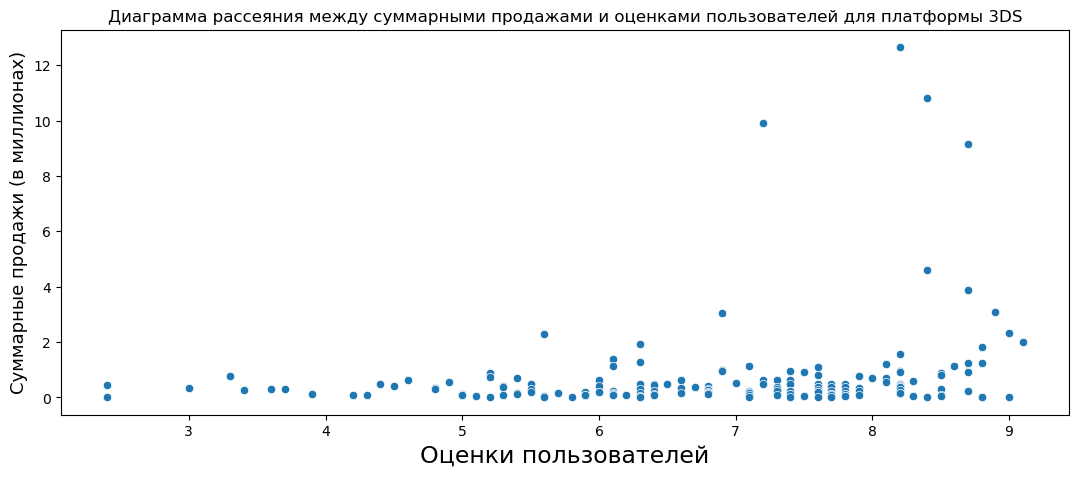

Корреляция суммарных продаж с оценкой пользователей: 0.22207843643390882


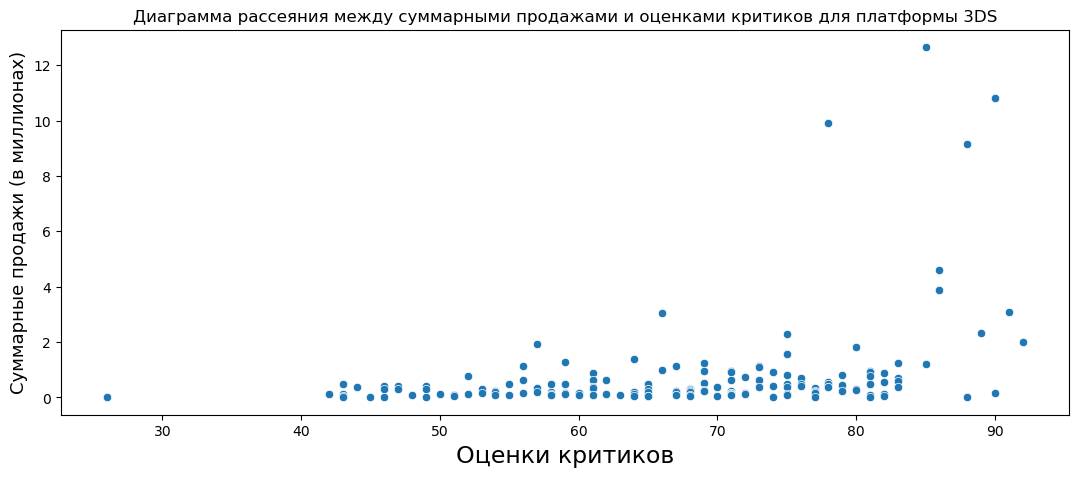

Корреляция суммарных продаж с оценкой критиков: 0.3487397305984834 
 
 



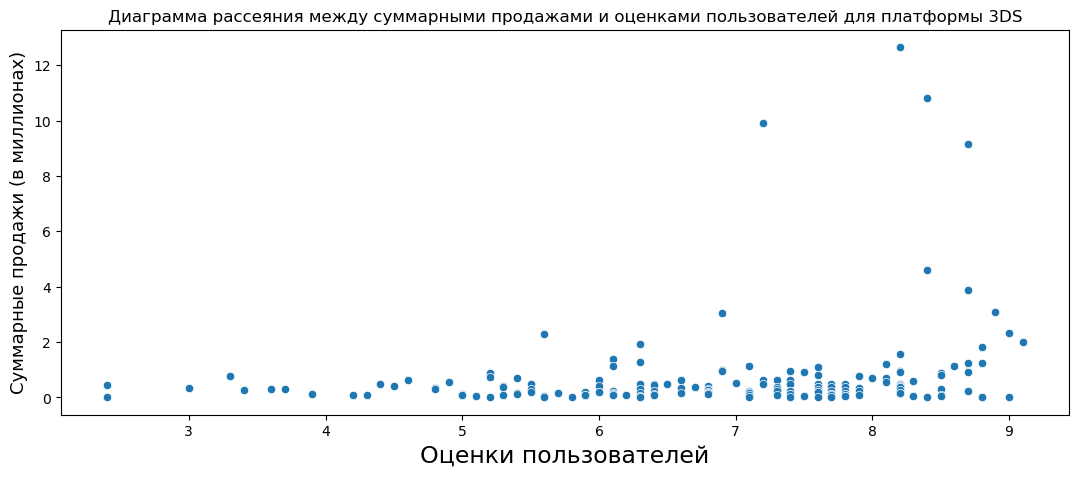

Корреляция суммарных продаж с оценкой пользователей: 0.22207843643390882


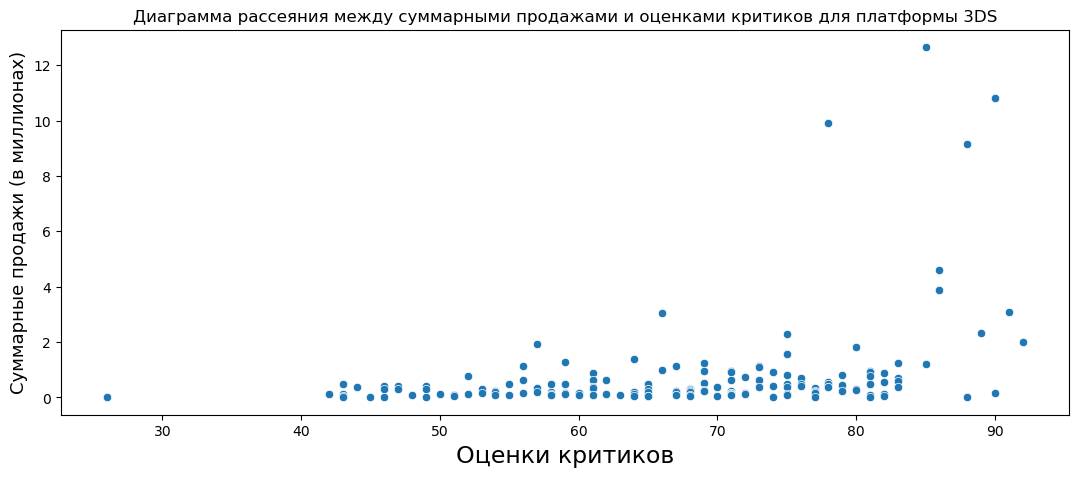

Корреляция суммарных продаж с оценкой критиков: 0.3487397305984834 
 
 



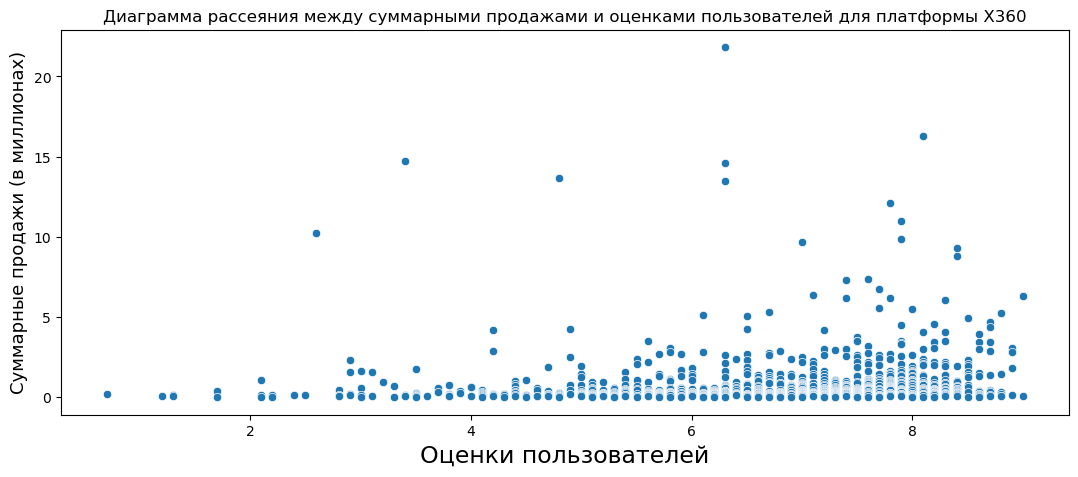

Корреляция суммарных продаж с оценкой пользователей: 0.11418661214018047


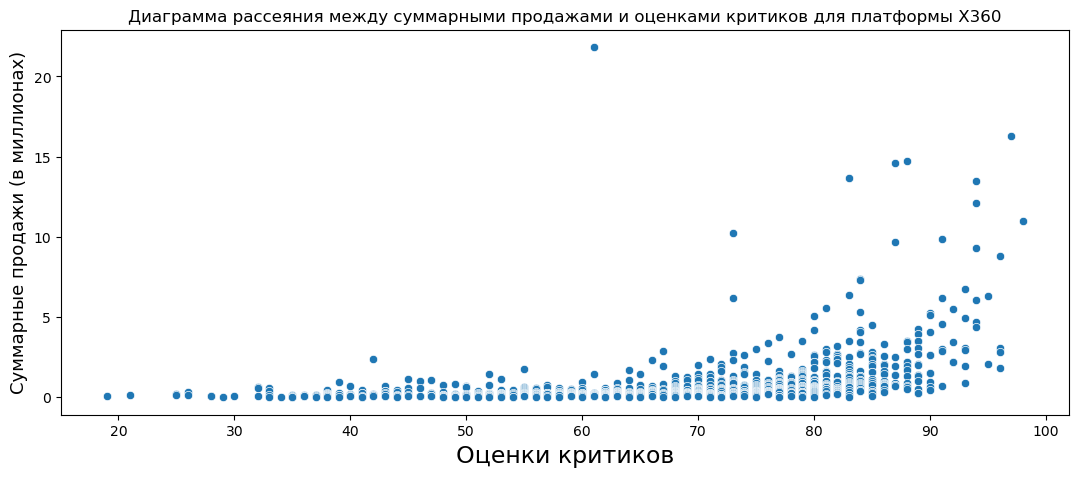

Корреляция суммарных продаж с оценкой критиков: 0.3928658925400699 
 
 



In [34]:
actual_platform = ['PS4', 'XOne', '3DS', '3DS', 'X360']

for platform_name in actual_platform:
    corr_for_actual_platforms(platform_name)

Проанализировав полученные диаграммы рассеивания можно сделать следующие выводы:
- Корреляция между оценкой пользователей и суммой продаж очень мала в отличие от корреляции между оценкой критиков и суммой продаж. Поэтому стоит опираться в предположениях на оценки критиков, а не на оценки пользователей.
- Самая большая корреляция наблюдается между оценками критиков и суммой продаж для платформ "XOne" и "PS3"

Посмотрим на общее распределение суммы продаж игр по жанрам. 

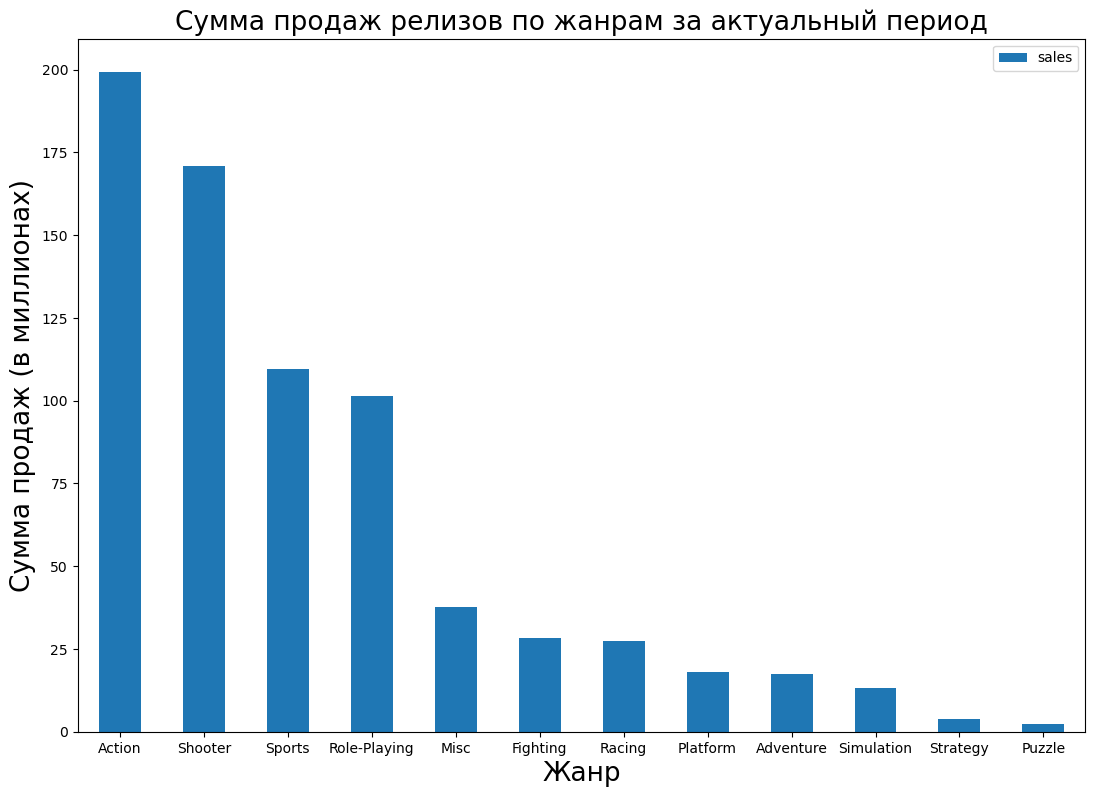

In [35]:
genre_sales = actual_df.pivot_table(index='genre', values='sales', aggfunc='sum').reset_index()
genre_sales.sort_values(by='sales', ascending=False, inplace=True)
genre_sales.plot.bar(x='genre', y='sales', figsize=(13, 9), rot=0)
plt.title('Сумма продаж релизов по жанрам за актуальный период', size=19)
plt.xlabel('Жанр', size=19)
plt.ylabel('Сумма продаж (в миллионах)', size=19)
plt.show()

Мы видим, что больше всего суммы продаж среди жанров "Action" и "Shooter". За ними с существенным оставанием идут "Sports" и "Role-Playing". Это, отнюдь не значит, что эти жанры самые прибыльные. Возможно, в этих жанрах просто выпускается много игр или некоторые релизы являются выбросами и значительно повышают среднюю цену. Для цели нашего исследования больше подходит вариант рассмотреть медианные цены продаж релизов по жанрам.

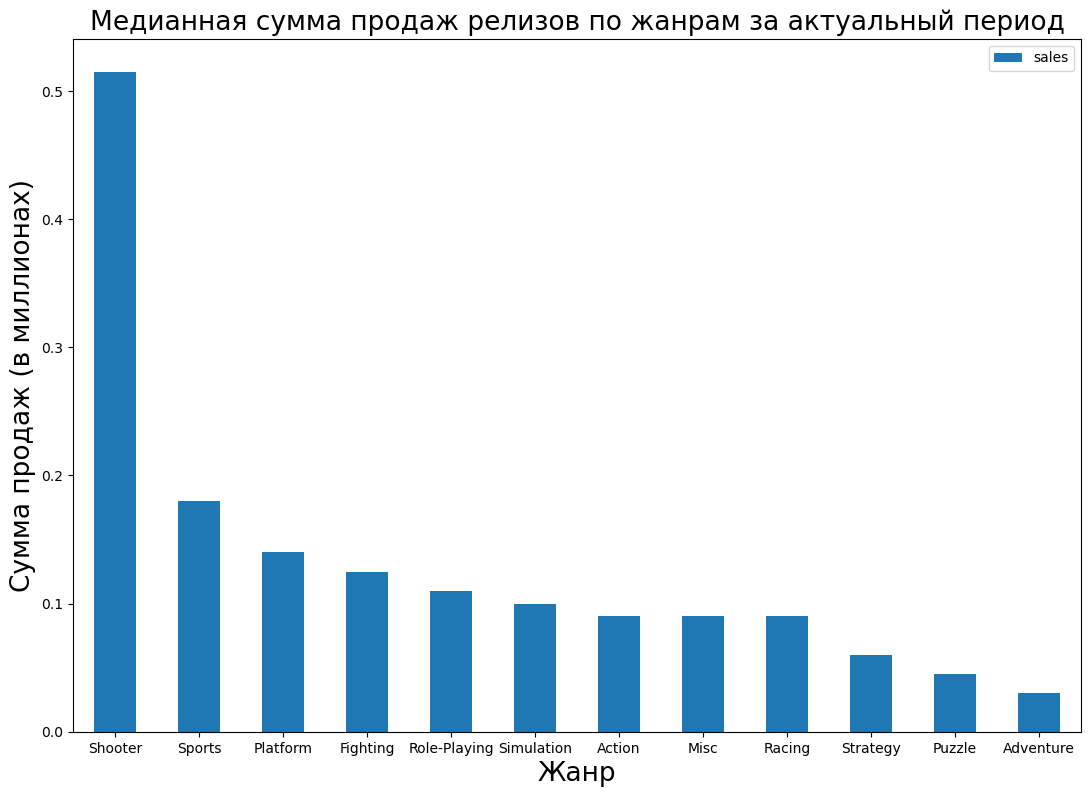

In [36]:
genre_sales_median = actual_df.pivot_table(index='genre', values='sales', aggfunc='median').reset_index()
genre_sales_median.sort_values(by='sales', ascending=False, inplace=True)
genre_sales_median.plot.bar(x='genre', y='sales', figsize=(13, 9), rot=0)
plt.title('Медианная сумма продаж релизов по жанрам за актуальный период', size=19)
plt.xlabel('Жанр', size=19)
plt.ylabel('Сумма продаж (в миллионах)', size=19)
plt.show()

Среди всех жанров лидером по медиане продаж релиза игры является "Shooter", за ним идёт "Sports" и "Platform".
Построим диаграмму размаха чтобы подтвердить или опровергнуть наше предположение о выбросах.

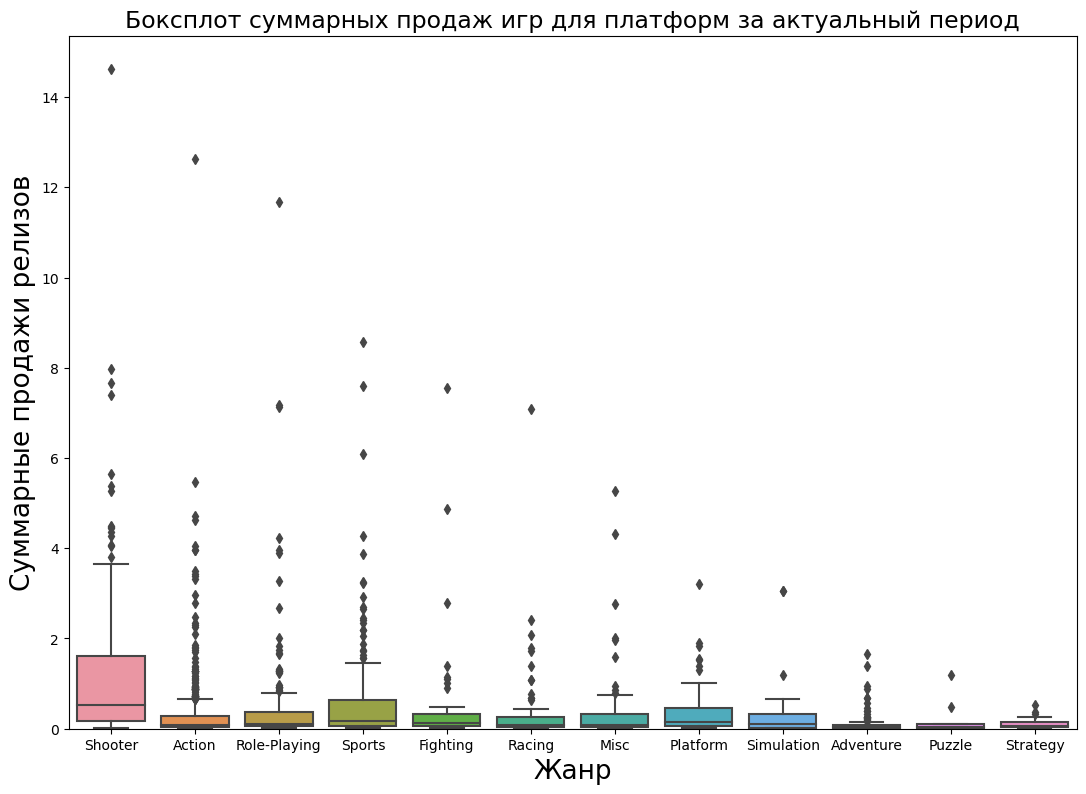

In [37]:
plt.figure(figsize=(13,9))
sb.boxplot(data=actual_df, x='genre', y='sales')
plt.title('Боксплот суммарных продаж игр для платформ за актуальный период', size=17)
plt.ylim(bottom=0)
plt.xlabel('Жанр', fontsize=19)
plt.ylabel('Суммарные продажи релизов',fontsize=19)
plt.show()

Предположение подтвердилось, для нашей цели лучше использовать медиану.

Подведём итоги 3-го этапа нашего исследования: 
- Начиная с 1995 года количество новых релизов начало резко возрастать каждые пять лет до 2010, после этого года произошёл резкий спад количества релизов, в 2016 году произошёл ещё более резкий скачок вверх (учитывая при этом то, что данные за этот год могут быть неполными). 
- Актуальным периодом будут являться года с 2014 по 2016.
- Платформами с наибольшими суммарными продажами  за актуальный период являются PS4, XOne, 3DS, PS3 и X360. Суммарные продажи релизов продолжают расти только для PS4 и XOne.
- В среднем платформы "живут" 6-9 лет.
- Корреляция между оценкой пользователей и суммой продаж очень мала в отличие от корреляции между оценкой критиков и суммой продаж. Поэтому стоит опираться в предположениях на оценки критиков, а не на оценки пользователей.
- Больше всего суммы продаж среди жанров "Action" и "Shooter". За ними с существенным оставанием идут "Sports" и "Role-Playing". 
- Среди всех жанров лидером по медиане продаж релиза игры является "Shooter", за ним идёт "Sports" и "Platform".

## Составление портрета пользователя каждого региона

Для составления портрета пользователя из конкретного региона возьмём следующие значения:
- Топ-5 самых популярных платформ в регионе.
- Топ-5 самых популярных жанров в регионе.
- Самые распространённые рейтинги ESRB в регионе.

При составлении портрета посмотрим также данные и за всё время. Это может пригодится при разработке рекламы не только для современный гемеров, но и для олдфагов.

### Портрет пользователя из региона NA (Северная Америка)

Определим самые популярные платформы в этом регионе.

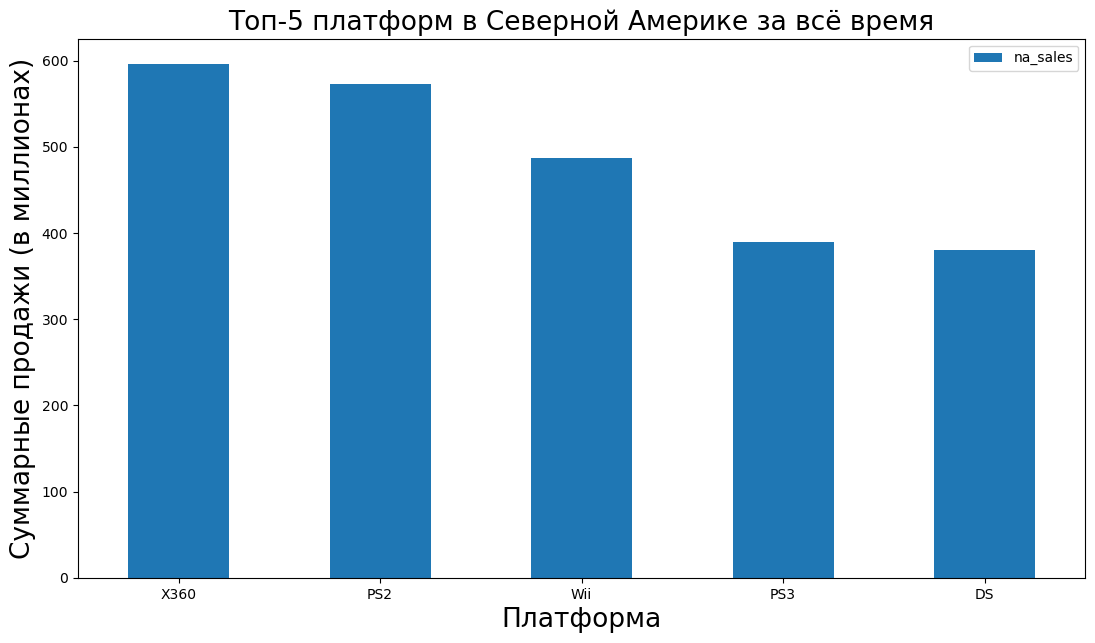

In [38]:
top_5_platform_na = (df.pivot_table(index='platform', values=['na_sales'], aggfunc='sum')
                     .sort_values(by='na_sales', ascending=False).head(5))

top_5_platform_na.plot.bar(figsize=(13, 7), rot=0)
plt.title('Топ-5 платформ в Северной Америке за всё время', size=19)
plt.xlabel('Платформа', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

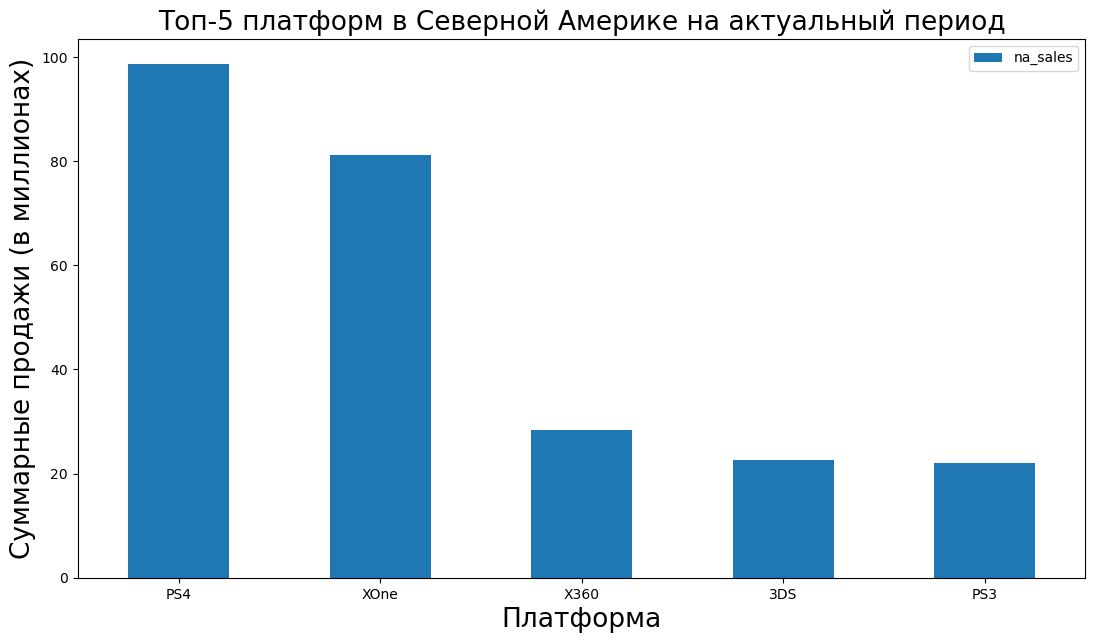

In [39]:
actual_df = df.query('year_of_release > 2013').reset_index()
top_5_actual_platform_na = (actual_df.pivot_table(index='platform', values=['na_sales'], aggfunc='sum')
                     .sort_values(by='na_sales', ascending=False).head(5))

top_5_actual_platform_na.plot.bar(figsize=(13, 7), rot=0)
plt.title('Топ-5 платформ в Северной Америке на актуальный период', size=19)
plt.xlabel('Платформа', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

Оценим доли (в процентах) региональных сумм продаж релизов по платформам от общего сумм продаж по платформам в регионе за актуальный период.

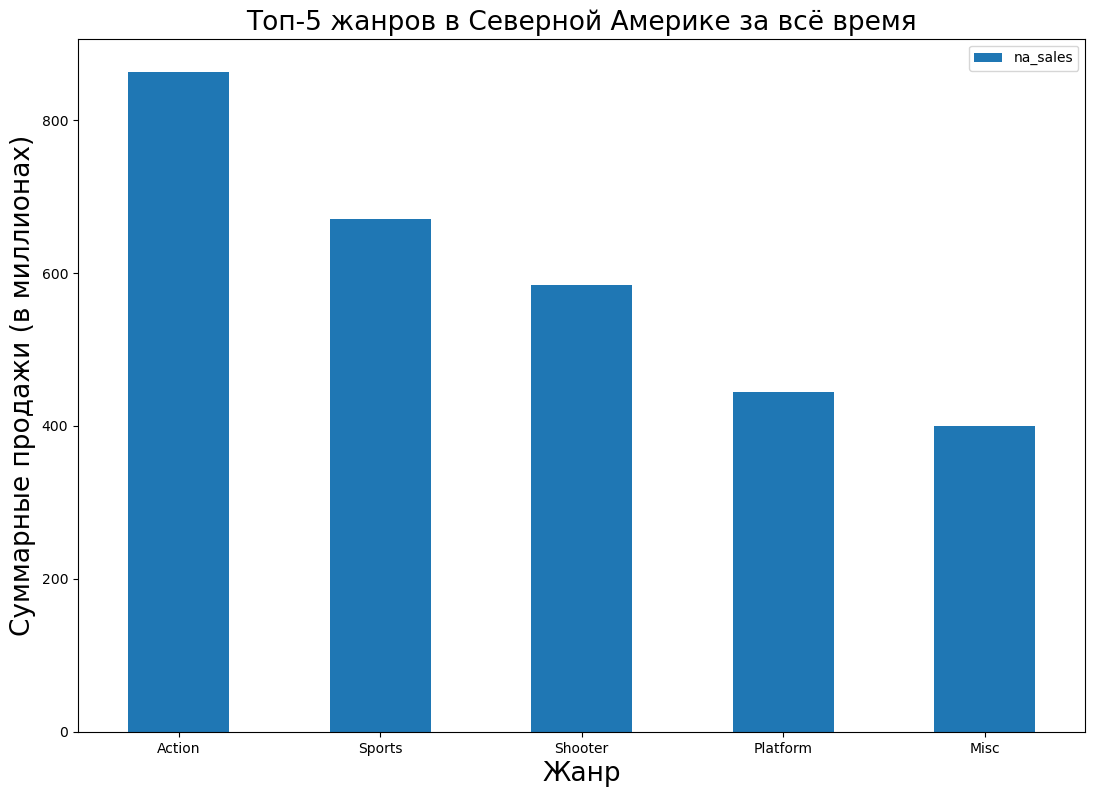

In [40]:
top_5_genre_na = (df.pivot_table(index='genre', values=['na_sales'], aggfunc='sum')
                     .sort_values(by='na_sales', ascending=False).head(5))

top_5_genre_na.plot.bar(figsize=(13, 9), rot=0)
plt.title('Топ-5 жанров в Северной Америке за всё время', size=19)
plt.xlabel('Жанр', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

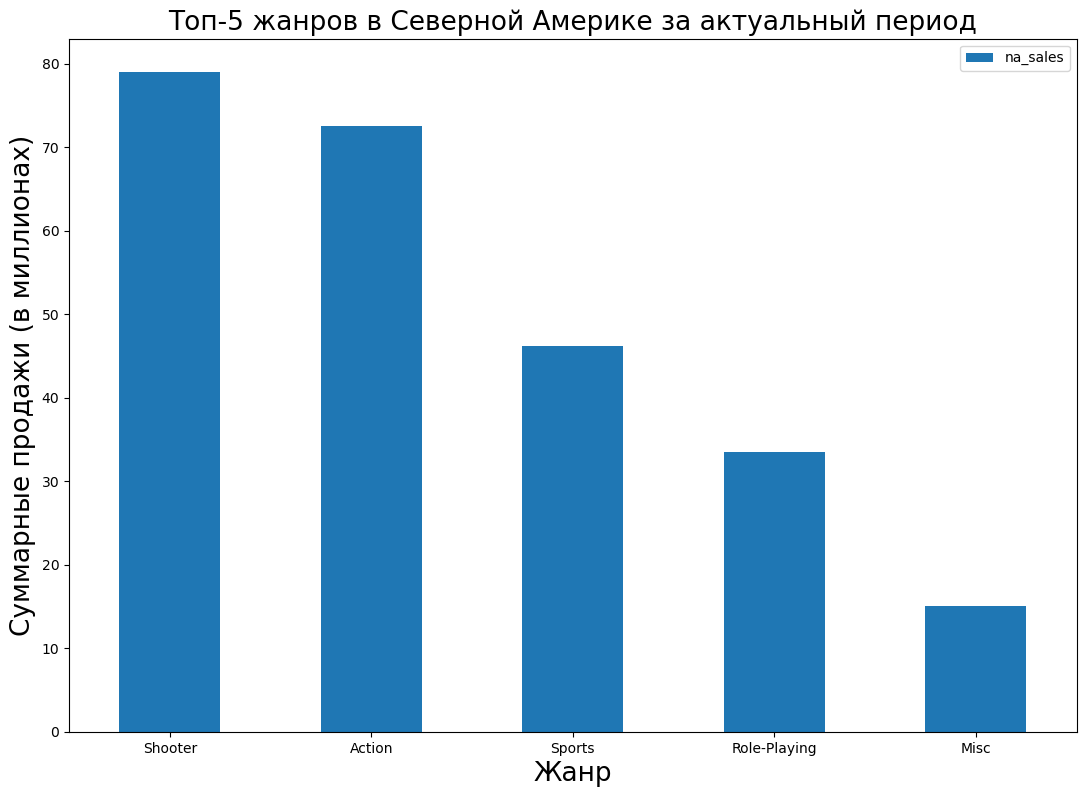

In [41]:
top_5_actual_genre_na = (actual_df.pivot_table(index='genre', values=['na_sales'], aggfunc='sum')
                         .sort_values(by='na_sales', ascending=False).head(5))

top_5_actual_genre_na.plot.bar(figsize=(13, 9), rot=0)
plt.title('Топ-5 жанров в Северной Америке за актуальный период', size=19)
plt.xlabel('Жанр', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

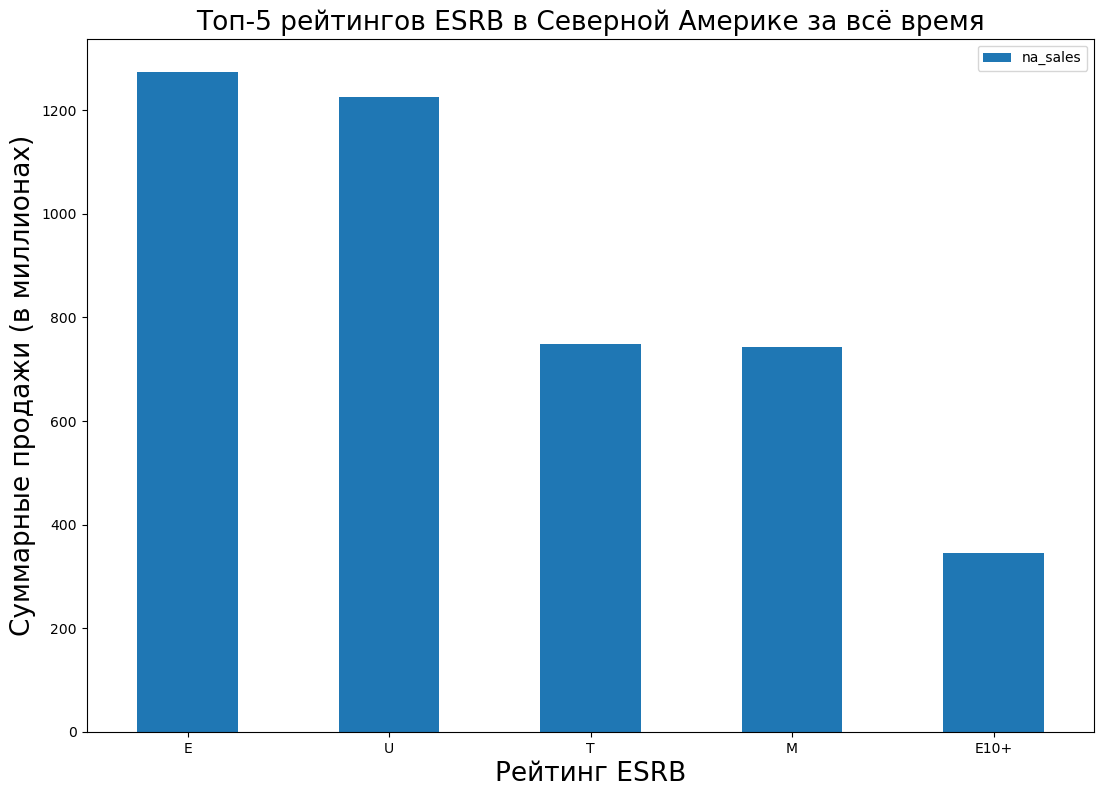

In [42]:
top_5_rating_na = (df.pivot_table(index='rating', values=['na_sales'], aggfunc='sum')
                   .sort_values(by='na_sales', ascending=False).head(5))

top_5_rating_na.plot.bar(figsize=(13, 9), rot=0)
plt.title('Топ-5 рейтингов ESRB в Северной Америке за всё время', size=19)
plt.xlabel('Рейтинг ESRB', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

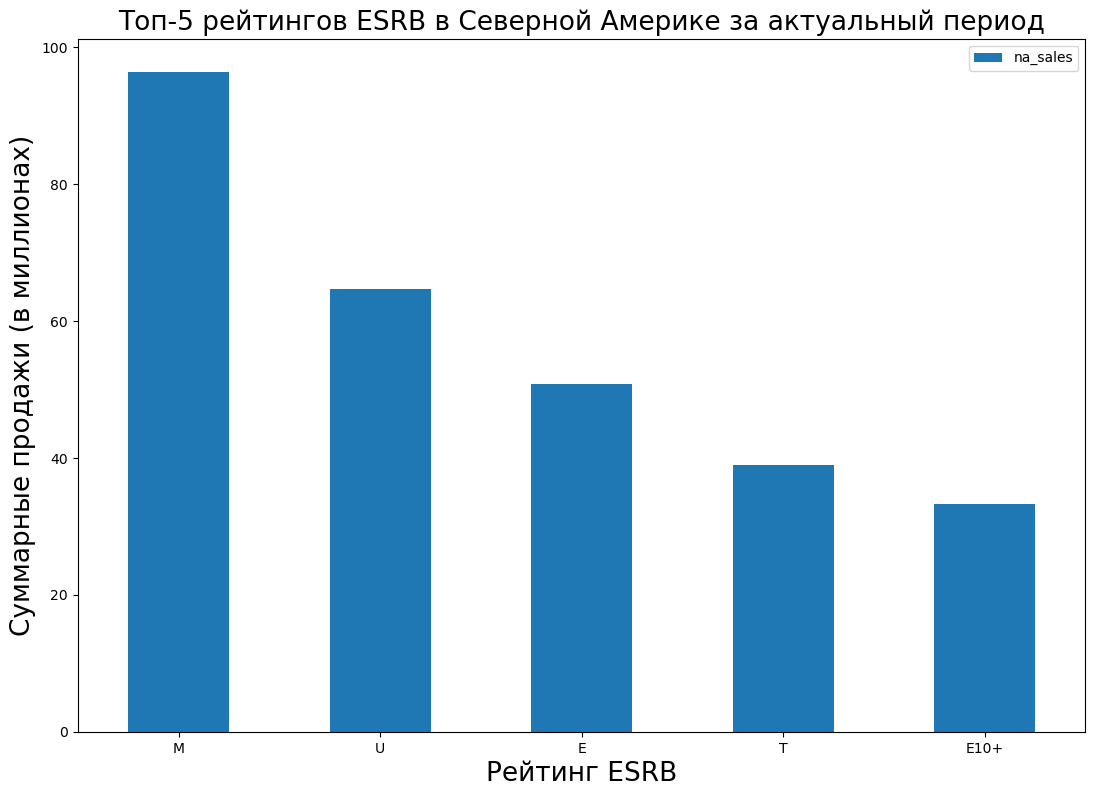

In [43]:
top_5_actual_rating_na = (actual_df.pivot_table(index='rating', values=['na_sales'], aggfunc='sum')
                     .sort_values(by='na_sales', ascending=False).head(5))

top_5_actual_rating_na.plot.bar(figsize=(13, 9), rot=0)
plt.title('Топ-5 рейтингов ESRB в Северной Америке за актуальный период', size=19)
plt.xlabel('Рейтинг ESRB', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

Примерный портрет пользователя региона Северная Америка за всё время:
- Платформа:
    1. X360
    2. PS2
    3. Wii
    4. PS3
    5. DS
- Жанр:
    1. Action
    2. Sports
    3. Shooter
    4. Platform
    5. Misc
- Рейтинг ESRB:
    1. E - "Для всех"
    2. U - "Неизвестен"
    3. T - «Подросткам»
    4. M - «Для взрослых»
    5. E10+ - «Для всех от 10 лет и старше»
    
    
Примерный портрет пользователя региона Северная Америка за актуальный период:
- Платформа:
    1. PS4
    2. XOne
    3. X360
    4. 3DS
    5. PS3
- Жанр:
    1. Shooter
    2. Action
    3. Sports
    4. Role-Playing
    5. Misc
- Рейтинг ESRB:
    1. M - «Для взрослых»
    2. U - "Неизвестен"
    3. E - "Для всех
    4. T - «Подросткам»
    5. E10+ - «Для всех от 10 лет и старше»

### Портрет пользователя из региона EU (Европа)

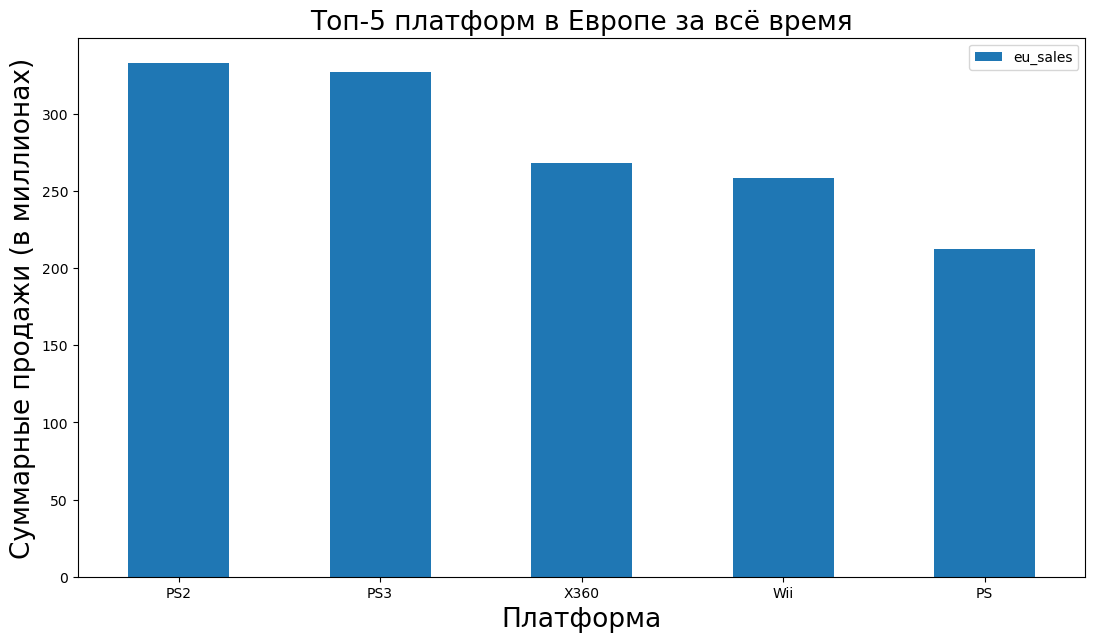

In [44]:
top_5_platform_eu = (df.pivot_table(index='platform', values=['eu_sales'], aggfunc='sum')
                     .sort_values(by='eu_sales', ascending=False).head(5))

top_5_platform_eu.plot.bar(figsize=(13, 7), rot=0)
plt.title('Топ-5 платформ в Европе за всё время', size=19)
plt.xlabel('Платформа', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

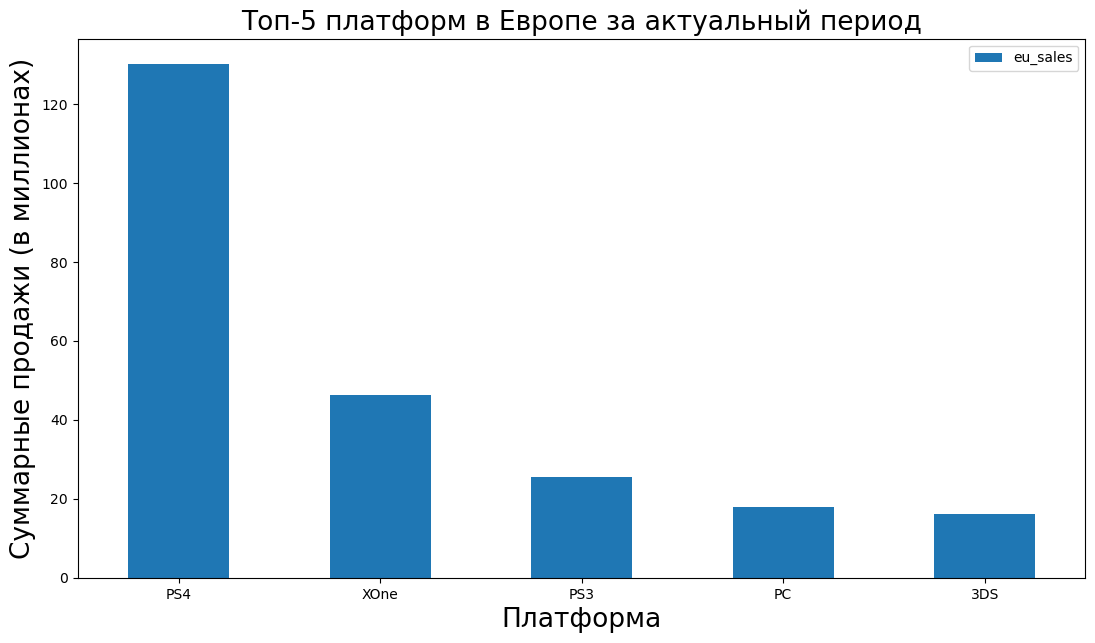

In [45]:
top_5_actual_platform_eu = (actual_df.pivot_table(index='platform', values=['eu_sales'], aggfunc='sum')
                            .sort_values(by='eu_sales', ascending=False).head(5))

top_5_actual_platform_eu.plot.bar(figsize=(13, 7), rot=0)
plt.title('Топ-5 платформ в Европе за актуальный период', size=19)
plt.xlabel('Платформа', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

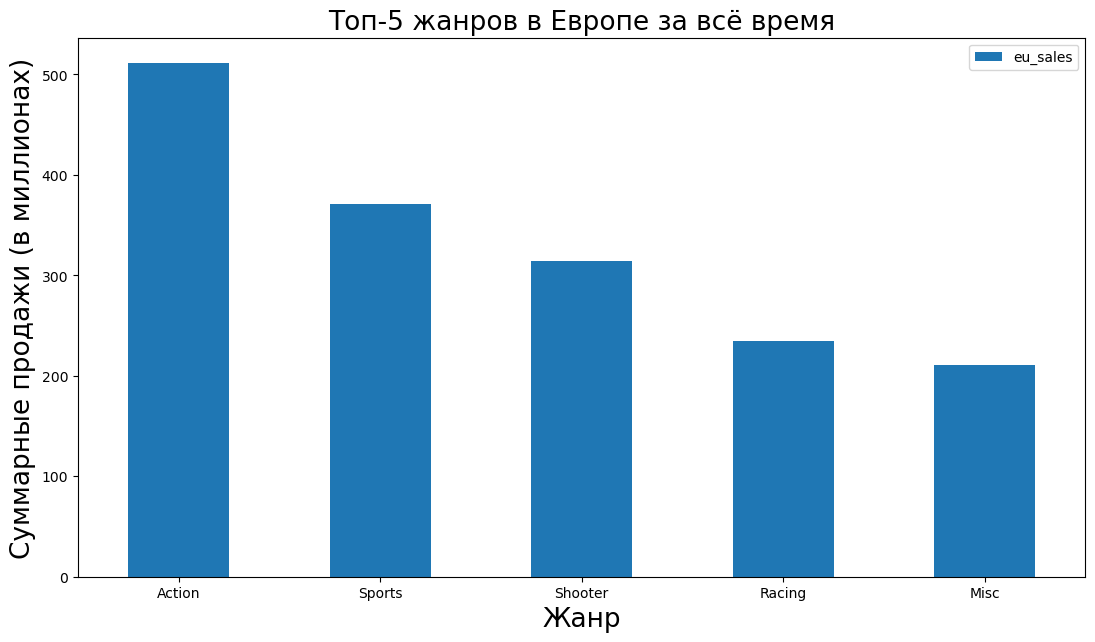

In [46]:
top_5_genre_eu = (df.pivot_table(index='genre', values=['eu_sales'], aggfunc='sum')
                     .sort_values(by='eu_sales', ascending=False).head(5))

top_5_genre_eu.plot.bar(figsize=(13, 7), rot=0)
plt.title('Топ-5 жанров в Европе за всё время', size=19)
plt.xlabel('Жанр', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

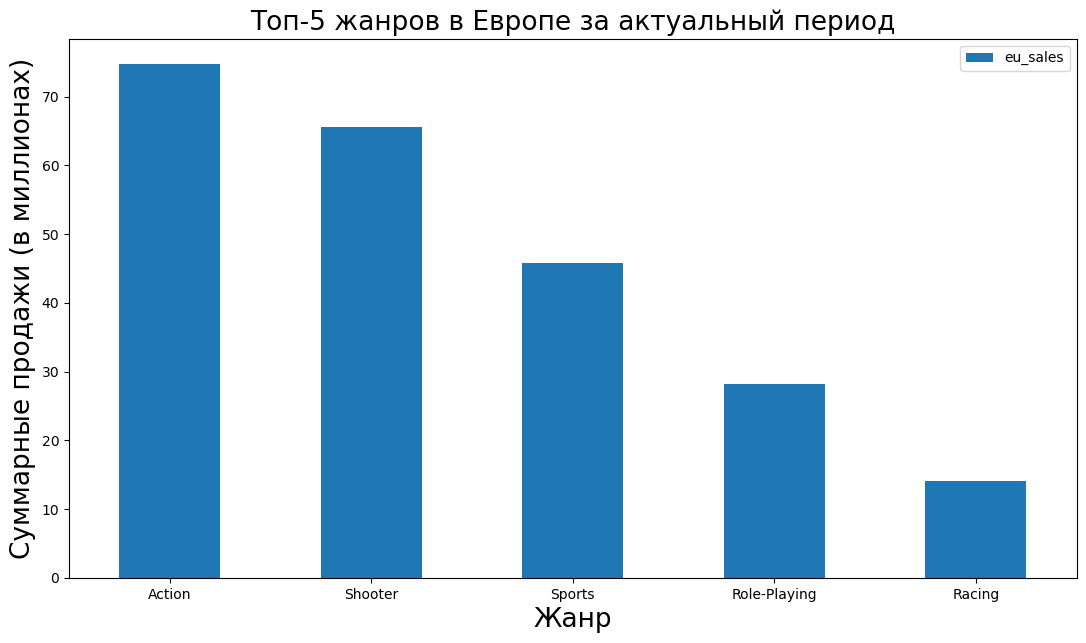

In [47]:
top_5_actual_genre_eu = (actual_df.pivot_table(index='genre', values=['eu_sales'], aggfunc='sum')
                     .sort_values(by='eu_sales', ascending=False).head(5))

top_5_actual_genre_eu.plot.bar(figsize=(13, 7), rot=0)
plt.title('Топ-5 жанров в Европе за актуальный период', size=19)
plt.xlabel('Жанр', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

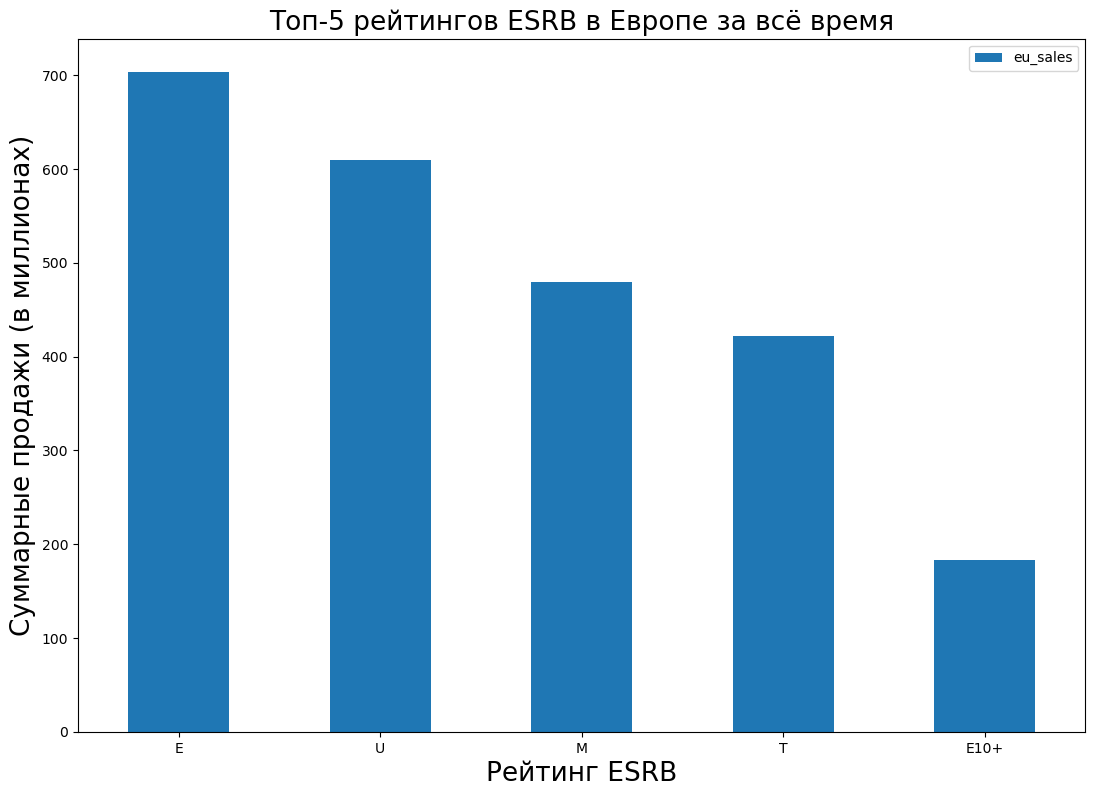

In [48]:
top_5_rating_eu = (df.pivot_table(index='rating', values=['eu_sales'], aggfunc='sum')
                     .sort_values(by='eu_sales', ascending=False).head(5))

top_5_rating_eu.plot.bar(figsize=(13, 9), rot=0)
plt.title('Топ-5 рейтингов ESRB в Европе за всё время', size=19)
plt.xlabel('Рейтинг ESRB', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

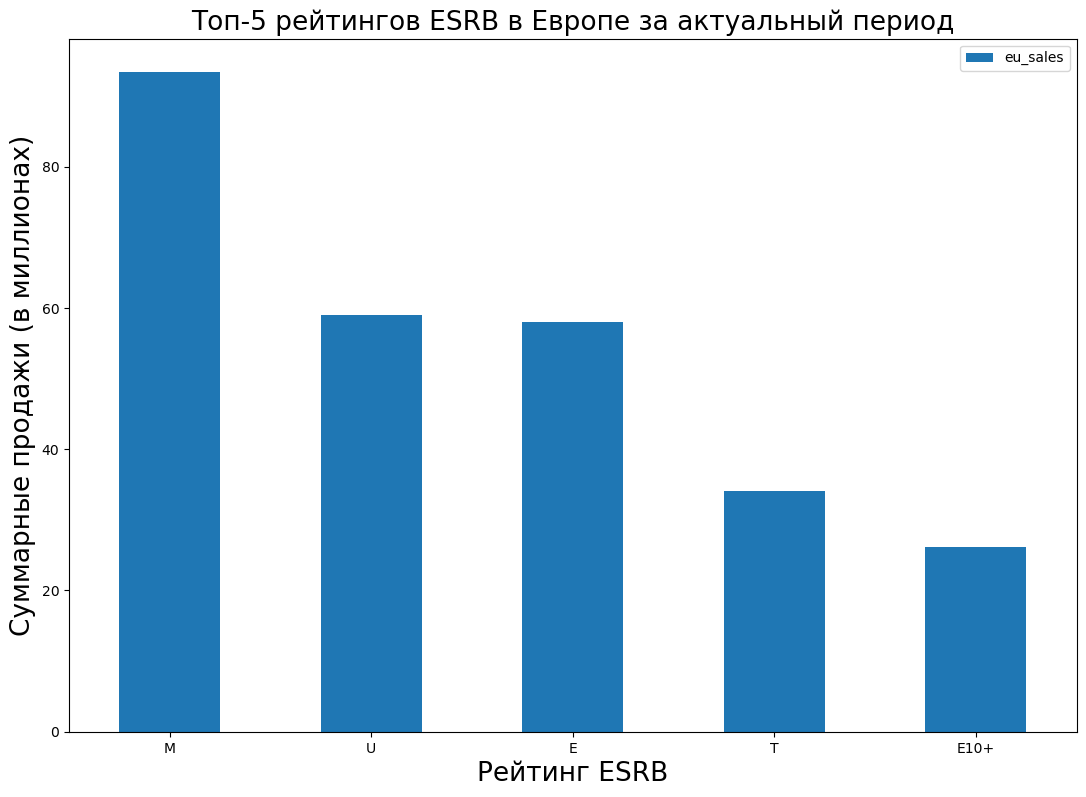

In [49]:
top_5_actual_rating_eu = (actual_df.pivot_table(index='rating', values=['eu_sales'], aggfunc='sum')
                          .sort_values(by='eu_sales', ascending=False).head(5))

top_5_actual_rating_eu.plot.bar(figsize=(13, 9), rot=0)
plt.title('Топ-5 рейтингов ESRB в Европе за актуальный период', size=19)
plt.xlabel('Рейтинг ESRB', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

Примерный портрет пользователя региона Европа за всё время:
- Платформа:
    1. PS2
    2. PS3
    3. X360
    4. Wii
    5. PS
- Жанр:
    1. Action
    2. Sports
    3. Shooter
    4. Racing
    5. Misc
- Возрастной рейтинг:
    1. E - «Для всех»
    2. U - "Неизвестен"
    3. M - «Для взрослых»
    4. T - «Подросткам»
    5. E10+ - «Для всех от 10 лет и старше»
    
    
Примерный портрет пользователя региона Европа за актуальный период:
- Платформа:
    1. PS4
    2. XOne
    3. PS3
    4. PC
    5. 3DS
- Жанр:
    1. Action
    2. Shooter
    3. Sports
    4. Role-Playing
    5. Racing
- Возрастной рейтинг:
    1. M - «Для взрослых»
    2. U - "Неизвестен"
    3. E - «Для всех»
    4. T - «Подросткам»
    5. E10+ - «Для всех от 10 лет и старше»

### Портрет пользователя из региона JP (Япония)

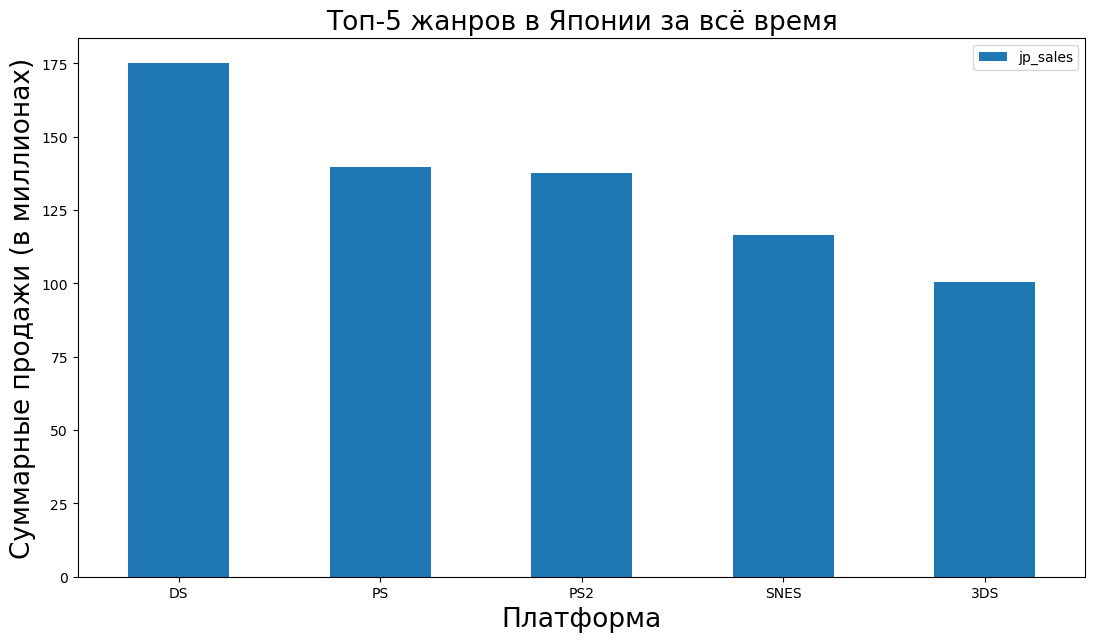

In [50]:
top_5_platform_jp = (df.pivot_table(index='platform', values=['jp_sales'], aggfunc='sum')
                     .sort_values(by='jp_sales', ascending=False).head(5))

top_5_platform_jp.plot.bar(figsize=(13, 7), rot=0)
plt.title('Топ-5 жанров в Японии за всё время', size=19)
plt.xlabel('Платформа', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

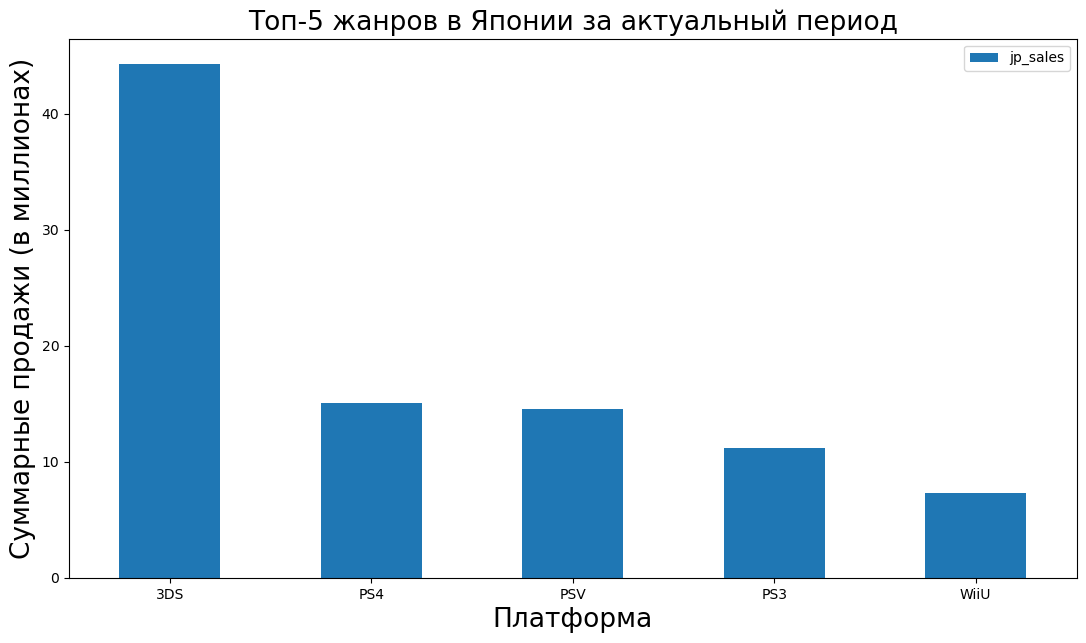

In [51]:
top_5_actual_platform_jp = (actual_df.pivot_table(index='platform', values=['jp_sales'], aggfunc='sum')
                     .sort_values(by='jp_sales', ascending=False).head(5))

top_5_actual_platform_jp.plot.bar(figsize=(13, 7), rot=0)
plt.title('Топ-5 жанров в Японии за актуальный период', size=19)
plt.xlabel('Платформа', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

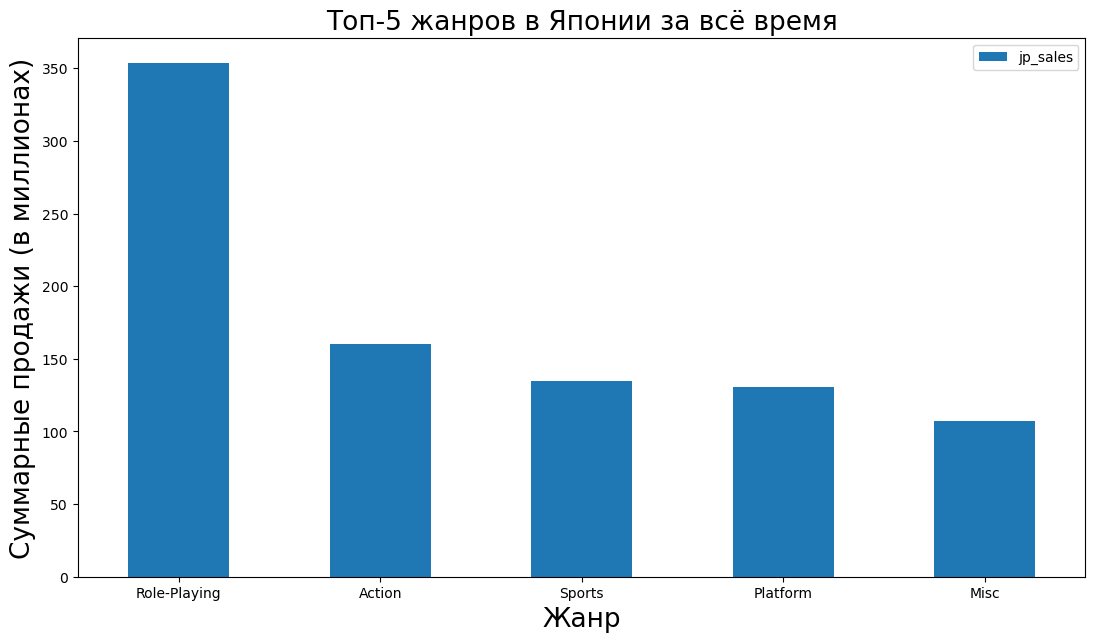

In [52]:
top_5_genre_jp = (df.pivot_table(index='genre', values=['jp_sales'], aggfunc='sum')
                     .sort_values(by='jp_sales', ascending=False).head(5))

top_5_genre_jp.plot.bar(figsize=(13, 7), rot=0)
plt.title('Топ-5 жанров в Японии за всё время', size=19)
plt.xlabel('Жанр', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

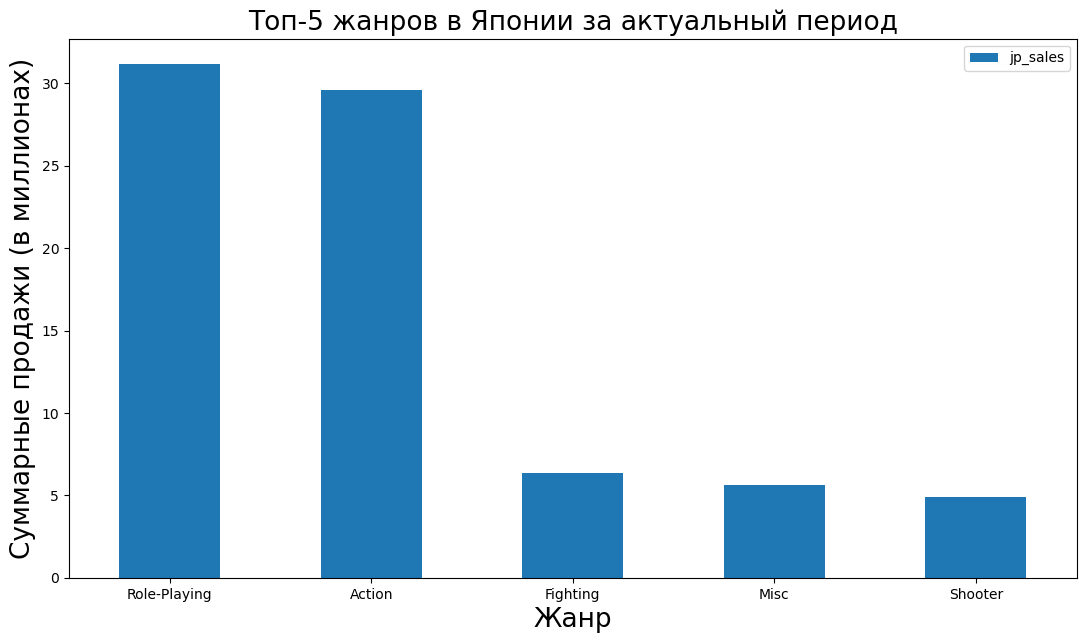

In [53]:
top_5_actual_genre_jp = (actual_df.pivot_table(index='genre', values=['jp_sales'], aggfunc='sum')
                     .sort_values(by='jp_sales', ascending=False).head(5))

top_5_actual_genre_jp.plot.bar(figsize=(13, 7), rot=0)
plt.title('Топ-5 жанров в Японии за актуальный период', size=19)
plt.xlabel('Жанр', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

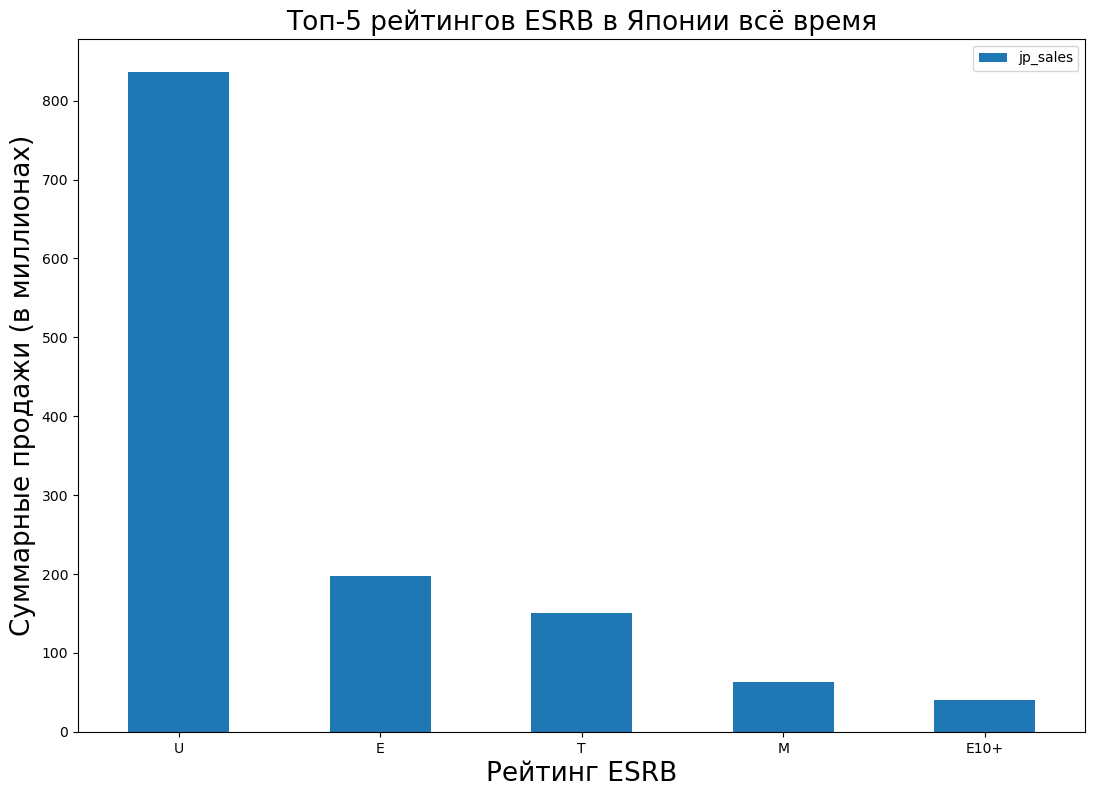

In [54]:
top_5_rating_jp = (df.pivot_table(index='rating', values=['jp_sales'], aggfunc='sum')
                     .sort_values(by='jp_sales', ascending=False).head(5))

top_5_rating_jp.plot.bar(figsize=(13, 9), rot=0)
plt.title('Топ-5 рейтингов ESRB в Японии всё время', size=19)
plt.xlabel('Рейтинг ESRB', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

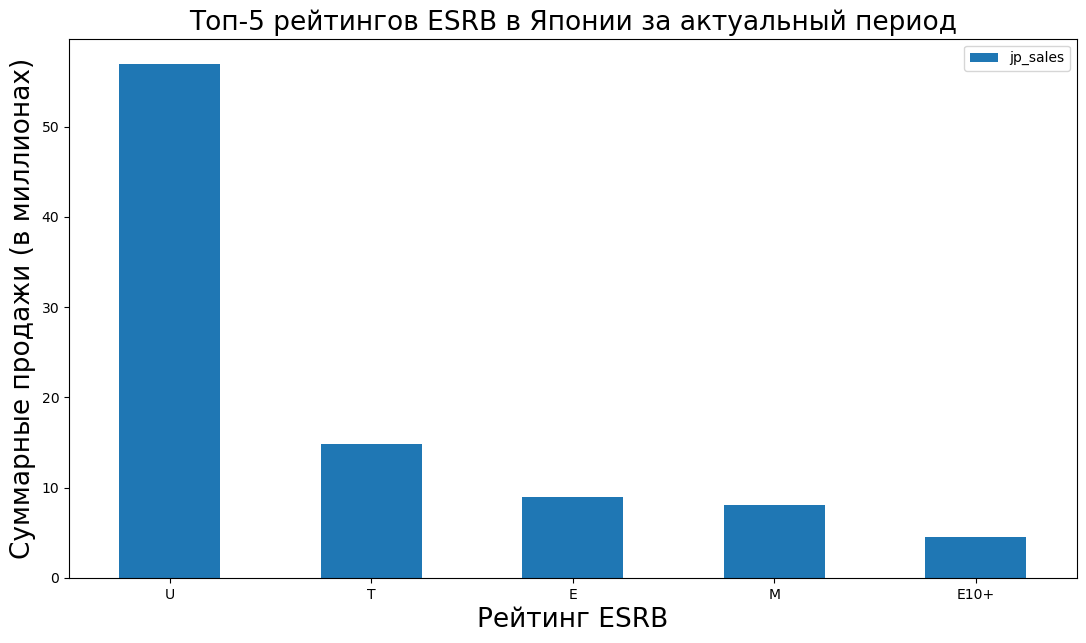

In [55]:
top_5_actual_rating_jp = (actual_df.pivot_table(index='rating', values=['jp_sales'], aggfunc='sum')
                         .sort_values(by='jp_sales', ascending=False).head(5))

top_5_actual_rating_jp.plot.bar(figsize=(13, 7), rot=0)
plt.title('Топ-5 рейтингов ESRB в Японии за актуальный период', size=19)
plt.xlabel('Рейтинг ESRB', size=19)
plt.ylabel('Суммарные продажи (в миллионах)', size=19)
plt.show()

Примерный портрет пользователя региона Япония за всё время:
- Платформа:
    1. DS
    2. PS
    3. PS2
    4. SNES
    5. 3DS
- Жанр:
    1. Role-Playing
    2. Action
    3. Sports
    4. Platform
    5. Misc
- Рейтинг ESRB:
    1. U - "Неизвестен"
    2. E - «Для всех»
    3. T - «Подросткам»
    4. M - «Для взрослых»
    5. E10+ - «Для всех от 10 лет и старше»
    
    
Примерный портрет пользователя региона Япония за актуальный период:
- Платформа:
    1. 3DS
    2. PS4
    3. PSV
    4. PS3
    5. WiiU
- Жанр:
    1. Role-Playing
    2. Action
    3. Fighting
    4. Misc
    5. Shooter
- Рейтинг ESRB:
    1. U - "Неизвестен"
    2. T - «Подросткам»
    3. E - «Для всех»
    4. M - «Для взрослых»
    5. E10+ - «Для всех от 10 лет и старше»

Влияние рейтинга ESRB на другие регионы, кроме NA оценить достаточно проблематично, поскольку он актуален в основном для Америки. Но можем сделать вывод о тенденции к росту рейтинга, а это значит что в актуальный период продаются лучше игры для более взрослой аудитории. 

Визуализируем топ-5 платформ по регионов по долям чтобы было наглядно видно какую долю на рынке занимает определённая платформа в регионе. Не вошедшие в топ платформы выделим отдельно как "Другие". 

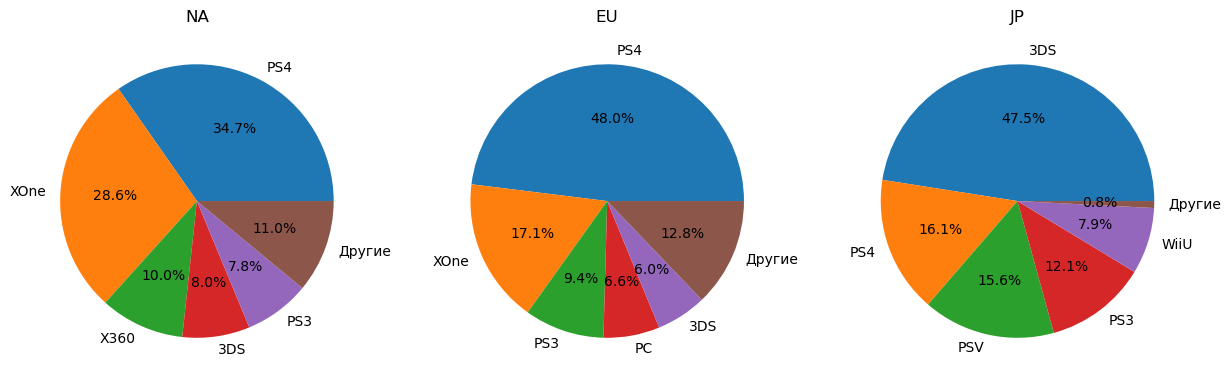

In [56]:
#Создаю сводную таблицу по платформам за актуальный период
top_platform_na = actual_df.pivot_table(index='platform', values='na_sales', aggfunc='sum')
#Добавляю столбец с подсчётом долей, сортирую значения
top_platform_na['prop'] = top_platform_na['na_sales'] / sum(top_platform_na['na_sales']) * 100
top_platform_na.sort_values(by='na_sales', ascending=False, inplace=True)
top_platform_na.reset_index(inplace=True)
#Беру топ-5
top_5_platform_na = top_platform_na[:5]
#Беру оставшиеся значения отдельно
other_na = top_platform_na[5:]
#Создаю словарь, в котором нужные мне данные для других платформ
temp = {'na_sales': [sum(other_na['na_sales'])], 'prop': [sum(other_na['prop'])], 'platform': ['Другие']}
#Создаю новый датафрейм из этих данных и добавляю его в датафрейм с топ-5
temp = pd.DataFrame(data=temp)
top_5_platform_na = top_5_platform_na.append(temp, ignore_index = True)

top_platform_eu = actual_df.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
top_platform_eu['prop'] = top_platform_eu['eu_sales'] / sum(top_platform_eu['eu_sales']) * 100
top_platform_eu.sort_values(by='eu_sales', ascending=False, inplace=True)
top_platform_eu.reset_index(inplace=True)
top_5_platform_eu = top_platform_eu[:5]
other_eu = top_platform_eu[5:]
temp = {'eu_sales': [sum(other_eu['eu_sales'])], 'prop': [sum(other_eu['prop'])], 'platform': ['Другие']}
temp = pd.DataFrame(data=temp)
top_5_platform_eu = top_5_platform_eu.append(temp, ignore_index = True)

top_platform_jp = actual_df.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
top_platform_jp['prop'] = top_platform_jp['jp_sales'] / sum(top_platform_jp['jp_sales']) * 100
top_platform_jp.sort_values(by='jp_sales', ascending=False, inplace=True)
top_platform_jp.reset_index(inplace=True)
top_5_platform_jp = top_platform_jp[:5]
other_jp = top_platform_jp[5:]
temp = {'jp_sales': [sum(other_jp['jp_sales'])], 'prop': [sum(other_jp['prop'])], 'platform': ['Другие']}
temp = pd.DataFrame(data=temp)
top_5_platform_jp = top_5_platform_jp.append(temp, ignore_index = True)

#Создаю график
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))
ax0.pie(top_5_platform_na['prop'], labels=top_5_platform_na['platform'], autopct='%.1f%%')
ax0.set_title('NA')
ax1.pie(top_5_platform_eu['prop'], labels=top_5_platform_eu['platform'], autopct='%.1f%%')
ax1.set_title('EU')
ax2.pie(top_5_platform_jp['prop'], labels=top_5_platform_jp['platform'], autopct='%.1f%%')
ax2.set_title('JP')
plt.show()

Теперь можно наглядно увидеть какие доли занимают самые популярные платформы среди всех в регионе. Сделаем тоже самое для жанров.

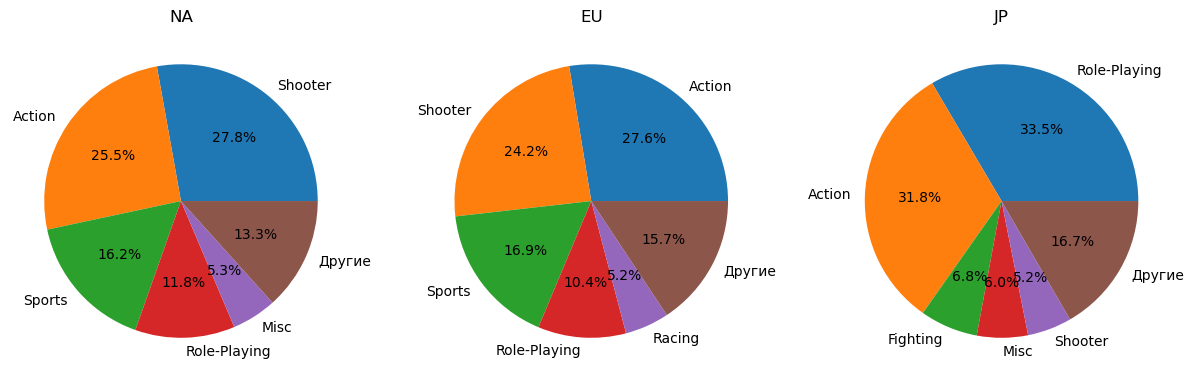

In [57]:
top_genre_na = actual_df.pivot_table(index='genre', values='na_sales', aggfunc='sum')
top_genre_na['prop'] = top_genre_na['na_sales'] / sum(top_genre_na['na_sales']) * 100
top_genre_na.sort_values(by='na_sales', ascending=False, inplace=True)
top_genre_na.reset_index(inplace=True)
top_5_genre_na = top_genre_na[:5]
other_na = top_genre_na[5:]
temp = {'na_sales': [sum(other_na['na_sales'])], 'prop': [sum(other_na['prop'])], 'genre': ['Другие']}
temp = pd.DataFrame(data=temp)
top_5_genre_na = top_5_genre_na.append(temp, ignore_index = True)

top_genre_eu = actual_df.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
top_genre_eu['prop'] = top_genre_eu['eu_sales'] / sum(top_genre_eu['eu_sales']) * 100
top_genre_eu.sort_values(by='eu_sales', ascending=False, inplace=True)
top_genre_eu.reset_index(inplace=True)
top_5_genre_eu = top_genre_eu[:5]
other_eu = top_genre_eu[5:]
temp = {'eu_sales': [sum(other_eu['eu_sales'])], 'prop': [sum(other_eu['prop'])], 'genre': ['Другие']}
temp = pd.DataFrame(data=temp)
top_5_genre_eu = top_5_genre_eu.append(temp, ignore_index = True)

top_genre_jp = actual_df.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
top_genre_jp['prop'] = top_genre_jp['jp_sales'] / sum(top_genre_jp['jp_sales']) * 100
top_genre_jp.sort_values(by='jp_sales', ascending=False, inplace=True)
top_genre_jp.reset_index(inplace=True)
top_5_genre_jp = top_genre_jp[:5]
other_jp = top_genre_jp[5:]
temp = {'jp_sales': [sum(other_jp['jp_sales'])], 'prop': [sum(other_jp['prop'])], 'genre': ['Другие']}
temp = pd.DataFrame(data=temp)
top_5_genre_jp = top_5_genre_jp.append(temp, ignore_index = True)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))
ax0.pie(top_5_genre_na['prop'], labels=top_5_genre_na['genre'], autopct='%.1f%%')
ax0.set_title('NA')
ax1.pie(top_5_genre_eu['prop'], labels=top_5_genre_eu['genre'], autopct='%.1f%%')
ax1.set_title('EU')
ax2.pie(top_5_genre_jp['prop'], labels=top_5_genre_jp['genre'], autopct='%.1f%%')
ax2.set_title('JP')
plt.show()

## Формулировка и проверка гипотез

В нашем исследовании нам необходимо проверить 2 гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

### Проверка 1-го утверждения

Сформулируем нулевую и альтернативную гипотезы для первого утверждения:

- H_0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
- H_1: Средние пользовательские рейтинги платформ Xbox One и PC отличаются.

Для проверки будем использовать `ttest_ind` поскольку мы проверяем гипотезу о равенстве средних двух генеральных совокупностей. Вычислим дисперсии для оценок пользователей разных платформ.

In [58]:
xone = actual_df[(actual_df['platform'] == 'XOne') & (actual_df['user_score'] >= 0)]['user_score']
pc = actual_df[(actual_df['platform'] == 'PC') & (actual_df['user_score'] >= 0)]['user_score']

print('Дисперсия оценок пользователей XOne:', xone.var(ddof=1))
print('Дисперсия оценок пользователей PC:', pc.var(ddof=1))

Дисперсия оценок пользователей XOne: 1.8910066518846989
Дисперсия оценок пользователей PC: 2.9011543151334522


Дисперсии сильно отличаются, учтём это, добавив значение False для аргумента `equal_var`

In [59]:
alpha = 0.05

results = st.ttest_ind(xone, pc, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


На основе имеющихся данных за актуальный период не удалось отвергнуть нулевую гипотезу. Ради интереса, вычислим средние оценки пользователей.

In [60]:
print(xone.mean())
pc.mean()

6.594545454545453


6.298360655737703

Как мы видим, средние оценок почти одинаковые. Нулевую гипотезу мы не можем отвергнуть. Судя по значению p-value можно утверждать, что при сравнении средних оценок платформ мы бы получали схожие значения с вероятностью в 61%.

### Проверка 2-го утверждения

Сформулируем нулевую и альтернативную гипотезы для второго утверждения:

- H_0: Средние пользовательские рейтинги жанров Action и Sports одинаковые.
- H_1: Средние пользовательские рейтинги жанров Action и Sports разные.

Для проверки будем использовать `ttest_ind` поскольку мы проверяем гипотезу о равенстве средних двух генеральных совокупностей. Вычислим дисперсии для оценок пользователей разных платформ.

In [61]:
action = actual_df[(actual_df['genre'] == 'Action') & (actual_df['user_score'] >= 0)]['user_score']
sports = actual_df[(actual_df['genre'] == 'Sports') & (actual_df['user_score'] >= 0)]['user_score']

print('Дисперсия оценок пользователей игр жанра "Action":', action.var(ddof=1))
print('Дисперсия оценок пользователей игр жанра "Sports":', sports.var(ddof=1))

Дисперсия оценок пользователей игр жанра "Action": 1.898476658476659
Дисперсия оценок пользователей игр жанра "Sports": 3.4469791276090476


Дисперсии сильно отличаются, учтём это, добавив значение False для аргумента `equal_var`

In [62]:
alpha = 0.05

results = st.ttest_ind(action, sports, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


На основе имеющихся данных за актуальный период мы отвергли нулевую гипотезу. Ради интереса, вычислим средние оценки пользователей.

In [63]:
print(action.mean())
sports.mean()

6.760606060606054


5.225196850393697

Как мы видим, средние оценок отличаются больше чем на балл. Нулевую гипотезу мы отвергнули. Такое малое значение p-value говорит о совсем незначительном шансе того, что оценки Acton и Sports будут равны.

## Общий вывод

В этом исследовании мы работали с данными, которые изначально содержали в себе пропуски, ошибки и аномалии:
- Нестандартные названия столбцов. Были приведены к общепринятому регистру.
- Типы данных в столбах, нарушающие логику. Были изменены:
    - Тип данных в year_of_release на `int`.
    - Тип данных в critic_score на `int`.
    - Изменён тип данных в user_score на `float`.
- Удалены пропуски из:
    - столбца `name`.
    - столбца `year_of_release`.
- Заменены пропуски на значение заглушку в:
    - столбце `critic_score`.
    - столбце `user_score`.
    - столбце `rating` (значение tbd заменено отдельной заглушкой)
- Также был добавлен столбец `sales`, содержащий данные об общих продажах релизов по миру.

В 3-ем этапе проекта "Исследовательский анализ данных" были сформулированы следующие выводы:
- Начиная с 1995 года количество новых релизов начало резко возрастать каждые пять лет до 2010. После этого года произошёл резкий спад количества релизов, в 2016 году произошёл резкий скачок вверх. 
- Выявлена закономерность изменения суммы продаж релизов каждые пять лет. 
- Актуальным периодом будут являться года с 2013 по 2016.
- Платформами с наибольшими суммарными продажами в актуальный период являются PS4, XOne, 3DS, PS3 и X360. 
- Суммарные продажи релизов продолжают расти только для PS4 и XOne.
- В среднем платформы "живут" 6-9 лет. Лучше расчитывать на меньший срок, в связи с ускоряющимся техническим прогрессом.
- Корреляция между оценкой пользователей и суммой продаж очень мала в отличие от корреляции между оценкой критиков и суммой продаж. Поэтому стоит опираться в предположениях на оценки критиков, а не на оценки пользователей.
- Больше всего суммы продаж среди жанров "Action" и "Shooter". За ними с существенным оставанием идут "Sports" и "Role-Playing". 
- Среди всех жанров лидером по медиане продаж релиза игры является "Shooter", за ним идёт "Sports" и "Platform".

В 4-ом этапе проекта были составлены портреты пользователей из разных регионов (рейтинг ESRB применим только к региону NA):
Для пользователя из региона Северная Америка:
- За всё время:
    - Самая популярная платформа-X360, жанр-Action, рейтинг ESRB-E.
- За актуальный период:
    - Самая популярная платформа-X360, жанр-Action, рейтинг ESRB-M.
Для пользователя из региона Европа:
- За всё время:
    - Самая популярная платформа-PS2, жанр-Action, рейтинг ESRB-E.
- За актуальный период:
    - Самая популярная платформа-PS3, жанр-Action, рейтинг ESRB-M.
Для пользователя из региона Япония:
- За всё время:
    - Самая популярная платформа-DS, жанр-Role-Playing, рейтинг ESRB-U (после E) 
- За актуальный период:
    - Самая популярная платформа-3DS, жанр-Role-Playing, рейтинг ESRB-U (после T)

Выявлена тенденция к увеличению возрастного рейтинга во всех регионах с течением времени. 
Визуализированы доли топ-5 платформ и жанров по регионам в актуальных период.

На 5-ом этапе мы формулировали гипотезы и проверяли их:
Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
- Нулевую гипотезу о равенстве пользовательских рейтингов релизов на платформах XOne и PC мы не можем отвергнуть. Судя по значению p-value можно утверждать, что при сравнении средних оценок платформ мы бы получали схожие значения с вероятностью в 61%.
- Нулевую гипотезу о равенстве пользовательских рейтингов релизов жанров Action и Sports мы отвергнули. Малое значение p-value говорит о совсем незначительном шансе того, что оценки Acton и Sports будут равны.

Итак, обобщая выводы этапов проекта, можно сказать, что успех игры зависит от множества факторов. При проведении компании, интернет-магазину "Стримчик" необходимо обратить внимание на:
- Платформы PS4, XOne, 3DS, PS3 и X360. Особенно стоит рассмотреть платформы PS4 и XOne, т.к. суммарные продажи релизов игр на них продолжают расти.
- Жанры Action, Shooter, а также Sports и Role-Playing.
- Желательно, чтобы игры имели хорошие оценки критиков.
- Возрастной рейтинг M или E.
- При проведении компании в различных регионах учитывать портрет пользователя.

"Идеальный" релиз для рекламной компании на 2017г:
Игра на PS4 или XOne в жанре Action с высоким возрастным рейтингом и оценками критиков.